## Análisis Estadístico de Heurísticas CDCL SAT

### 1. Configuración Inicial


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
import scikit_posthocs as sp


### 2. Preprocesamiento de Datos


In [2]:

df = pd.read_csv('resultados_experimento.csv', low_memory=False)

# Filtrar columnas relevantes
metricas = ['pureclauses', 'chronological', 'compacts', 'conflicts',
'backtracked', 'asymmetric', 'decisions', 'searched',
'elimrounds', 'elimsubst', 'elimres', 'ext.clause_calls',
'learned', 'fixed', 'instrounds', 'bumped', 'recomputed',
'promoted1', 'promoted2', 'lucky',
'total_process_time_since_initialization',
'total_real_time_since_initialization',
'maximum_resident_set_size_of_process', 'tiempo_segundos']

# Crear variable de combinación heurística
def identificar_heuristica(row):
    if row['vsids'] == 1 and row['dlis'] == 0 and row['restart'] == 1:
        return 'VSIDS+restart'
    elif row['vsids'] == 1 and row['dlis'] == 0 and row['restart'] == 0:
        return 'VSIDS+no-restart'
    elif row['vsids'] == 0 and row['dlis'] == 1 and row['restart'] == 1:
        return 'DLIS+restart'
    elif row['vsids'] == 0 and row['dlis'] == 1 and row['restart'] == 0:
        return 'DLIS+no-restart'
    else:
        return 'Otra'

df['heuristica'] = df.apply(identificar_heuristica, axis=1)

# Extraer tipo de problema del nombre del archivo
df['tipo_problema'] = df['nombre_cnf'].str.extract(r'([a-zA-Z]+)_')

# Columnas relevantes
caracteristicas = [
    'num_vars', 'num_clausulas', 'densidad', 'tamanio_prom_clausula', 'vars_positivas', 'vars_negativas'
]

# Filtrar datos (resueltos + TIMEOUT)
df_filtered = df.dropna(subset=caracteristicas + ['resultado'])


### Análisis de los problemas con TIMEOUT

In [3]:
# Definir columnas relevantes
cols_timeout = ['nombre_cnf', 'heuristica'] + caracteristicas

# Filtrar TIMEOUT
df_timeout = df[df['resultado'] == 'TIMEOUT'][cols_timeout]

# Mostrar tabla resumen de TIMEOUT
display(df_timeout)


,nombre_cnf,heuristica,num_vars,num_clausulas,densidad,tamanio_prom_clausula,vars_positivas,vars_negativas
4,random4sat_n2000_r10.88_5.cnf,VSIDS+restart,2000,21760,10.88,4.0,2000,2000
5,random4sat_n2000_r10.88_5.cnf,VSIDS+no-restart,2000,21760,10.88,4.0,2000,2000
6,random4sat_n2000_r10.88_5.cnf,DLIS+restart,2000,21760,10.88,4.0,2000,2000
7,random4sat_n2000_r10.88_5.cnf,DLIS+no-restart,2000,21760,10.88,4.0,2000,2000
12,random4sat_n1000_r9.88_13.cnf,VSIDS+restart,1000,9880,9.88,4.0,1000,1000
...,...,...,...,...,...,...,...,...
618,random3sat_n5000_r4.76_11.cnf,DLIS+no-restart,5000,23800,4.76,3.0,4994,4993
627,random3sat_n5000_r4.76_23.cnf,VSIDS+restart,5000,23800,4.76,3.0,4993,4996
628,random3sat_n5000_r4.76_23.cnf,VSIDS+no-restart,5000,23800,4.76,3.0,4993,4996
629,random3sat_n5000_r4.76_23.cnf,DLIS+restart,5000,23800,4.76,3.0,4993,4996


#### Interpretación de la tabla de TIMEOUT

Con base en el conjunto de resultados filtrados por TIMEOUT, se observa que las heurísticas evaluadas presentan diferencias claras en su comportamiento frente a instancias con distintas características estructurales. Por ejemplo, la heurística VSIDS combinada con reinicio tiende a experimentar TIMEOUT en instancias con menor número de variables pero con una densidad relativamente alta de cláusulas por variable, lo que sugiere que esta configuración puede ser menos efectiva en problemas más densos aunque de tamaño moderado. En contraste, DLIS sin reinicio acumula TIMEOUT en instancias con un mayor número de variables pero con densidad menor, indicando que esta heurística puede tener dificultades para escalar en problemas más grandes, aunque menos densos. Además, la presencia o ausencia de reinicios parece influir significativamente en el rendimiento, dado que las combinaciones con reinicio generalmente muestran un patrón distinto de TIMEOUT frente a las que no lo incorporan. Estas observaciones permiten suponer que la elección de heurística y estrategia de reinicio debe adaptarse a la estructura específica del problema SAT para optimizar el rendimiento y evitar fallos por límite de tiempo. Un análisis estadístico más profundo, incluyendo pruebas de significancia y visualizaciones, ayudaría a confirmar estas tendencias y a modelar predictivamente la probabilidad de TIMEOUT según las características del problema y la heurística aplicada



heuristica                   DLIS+no-restart  DLIS+restart  VSIDS+no-restart  \
num_vars              count        74.000000     74.000000         67.000000   
                      mean       2391.216216   2391.216216       2516.716418   
                      std        1645.295454   1645.295454       1652.965552   
                      min         110.000000    110.000000        420.000000   
                      25%        1000.000000   1000.000000       1000.000000   
                      50%        2000.000000   2000.000000       2000.000000   
                      75%        4387.500000   4387.500000       5000.000000   
                      max        5000.000000   5000.000000       5000.000000   
num_clausulas         count        74.000000     74.000000         67.000000   
                      mean      15757.837838  15757.837838      16875.895522   
                      std       13109.305923  13109.305923      13230.899315   
                      min         561.000000    561.000000       4221.000000   
                      25%        8520.000000   8520.000000       8520.000000   
                      50%        9880.000000   9880.000000       9908.000000   
                      75%       22788.500000  22788.500000      23800.000000   
                      max       63801.000000  63801.000000      63801.000000   
densidad              count        74.000000     74.000000         67.000000   
                      mean          7.450200      7.450200          7.748639   
                      std           5.388838      5.388838          5.580586   
                      min           4.076000      4.076000          4.175600   
                      25%           4.361625      4.361625          4.434200   
                      50%           4.760000      4.760000          4.760000   
                      75%           9.880000      9.880000          9.965000   
                      max          25.020000     25.020000         25.020000   
tamanio_prom_clausula count        74.000000     74.000000         67.000000   
                      mean          2.948418      2.948418          2.980781   
                      std           0.555888      0.555888          0.558642   
                      min           2.038369      2.038369          2.038369   
                      25%           3.000000      3.000000          3.000000   
                      50%           3.000000      3.000000          3.000000   
                      75%           3.000000      3.000000          3.000000   
                      max           4.000000      4.000000          4.000000   
vars_positivas        count        74.000000     74.000000         67.000000   
                      mean       2388.918919   2388.918919       2514.432836   
                      std        1643.636111   1643.636111       1651.253630   
                      min         110.000000    110.000000        420.000000   
                      25%        1000.000000   1000.000000       1000.000000   
                      50%        1998.000000   1998.000000       1998.000000   
                      75%        4379.250000   4379.250000       4991.000000   
                      max        5000.000000   5000.000000       5000.000000   
vars_negativas        count        74.000000     74.000000         67.000000   
                      mean       2388.783784   2388.783784       2514.223881   
                      std        1643.452191   1643.452191       1651.081618   
                      min         110.000000    110.000000        420.000000   
                      25%        1000.000000   1000.000000       1000.000000   
                      50%        1997.000000   1997.000000       1997.000000   
                      75%        4377.000000   4377.000000       4990.500000   
                      max        4999.000000   4999.000000       4999.000000   

heuristica                   VSIDS+restart  
num_vars              count      6

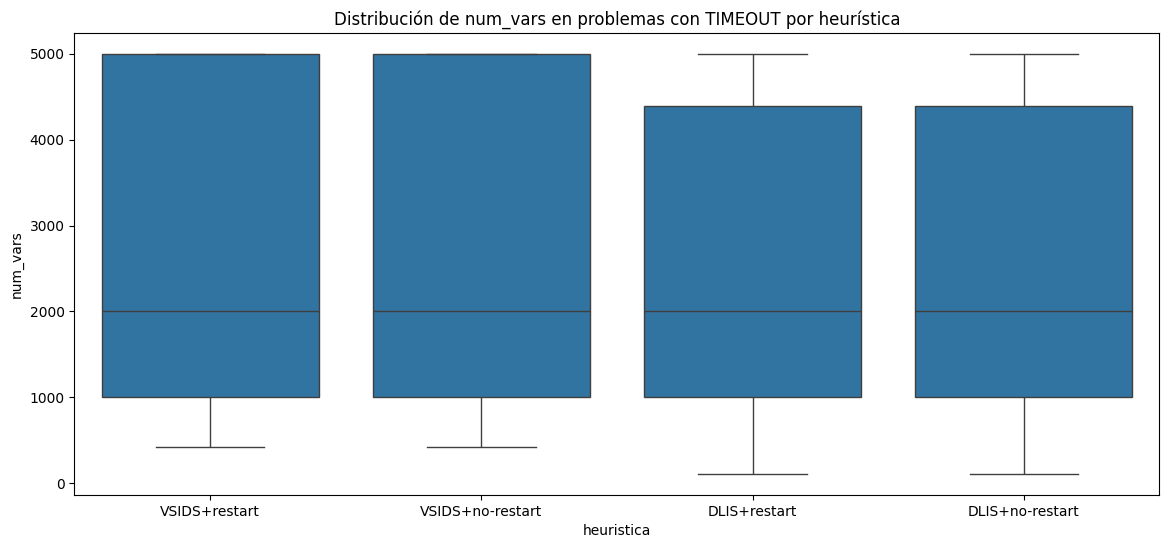

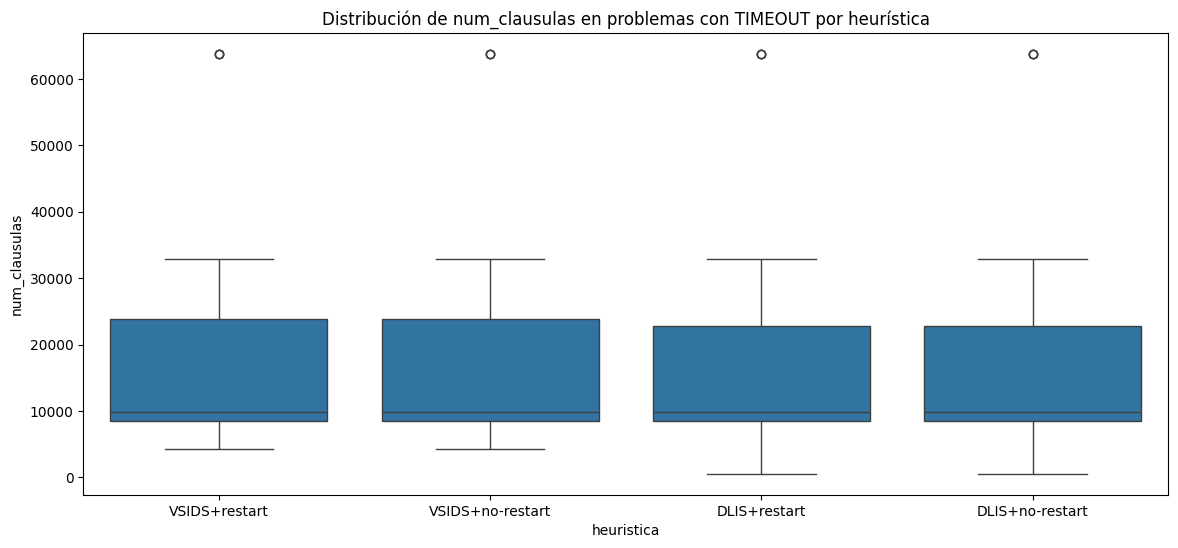

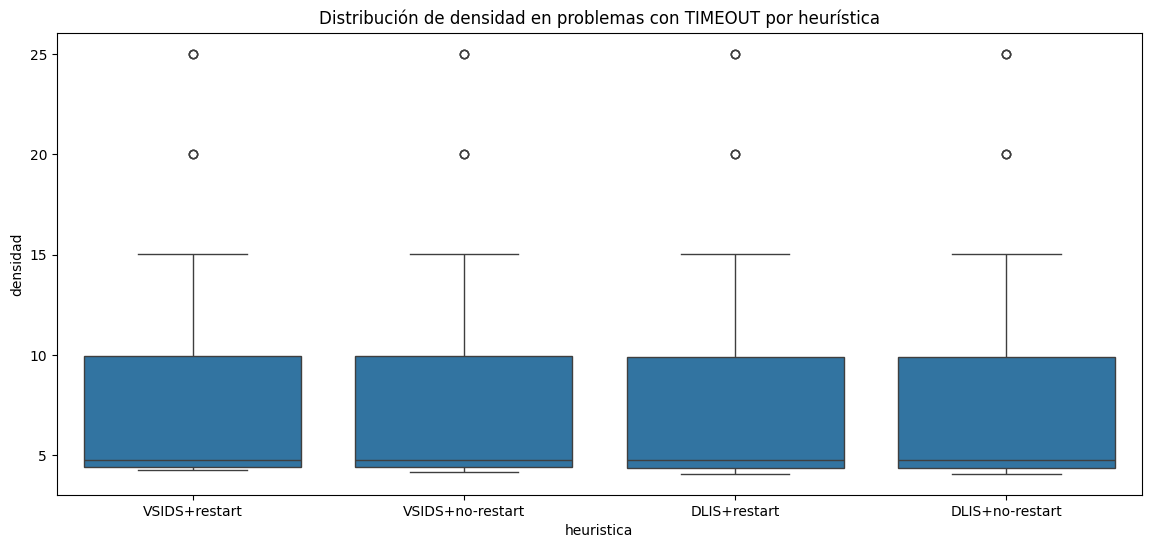

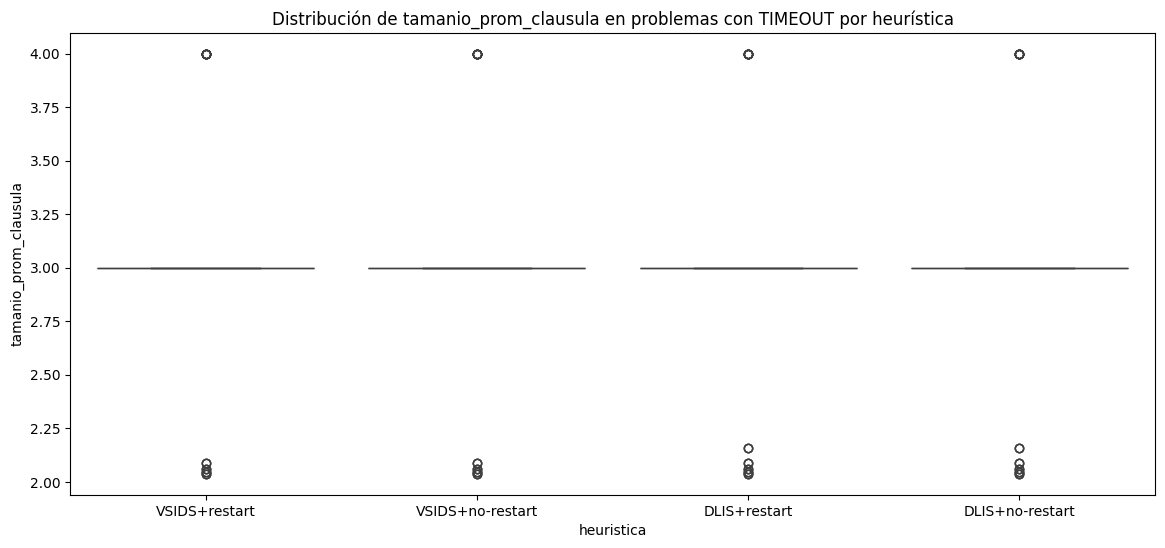

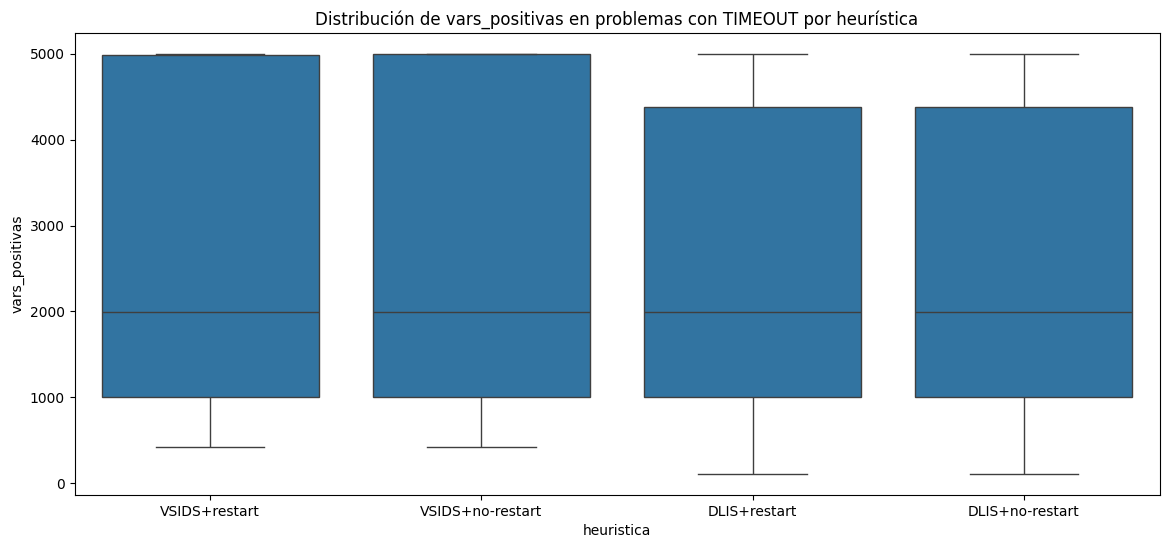

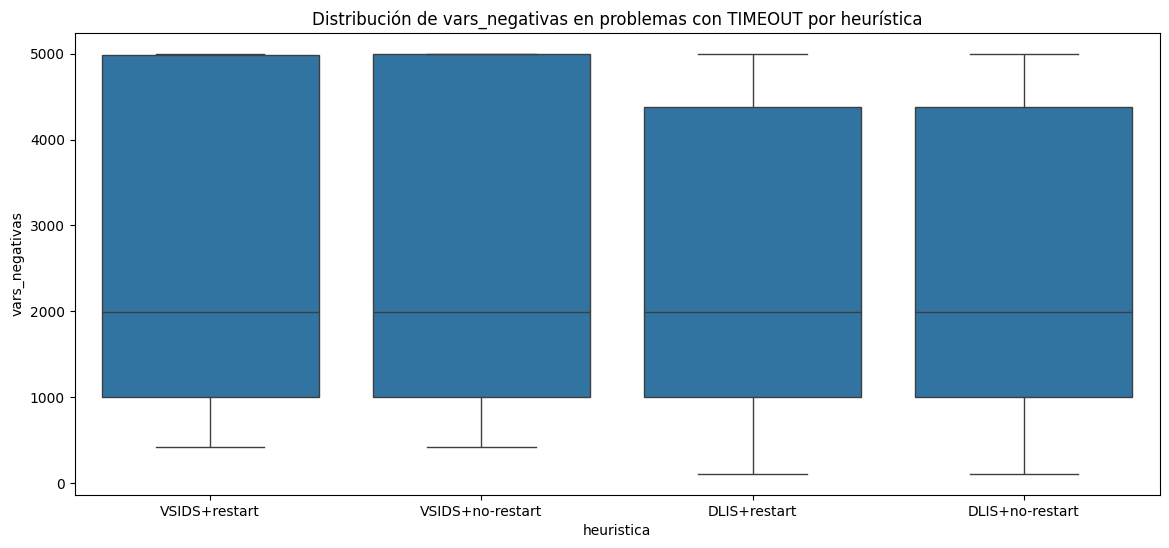

In [4]:
# Estadísticas descriptivas por heurística
timeout_stats = df_timeout.groupby('heuristica')[caracteristicas].describe().T
display(timeout_stats)

# Visualización: Distribución de características de problemas con TIMEOUT por heurística
plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='num_vars', data=df_timeout)
plt.title('Distribución de num_vars en problemas con TIMEOUT por heurística')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='num_clausulas', data=df_timeout)
plt.title('Distribución de num_clausulas en problemas con TIMEOUT por heurística')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='densidad', data=df_timeout)
plt.title('Distribución de densidad en problemas con TIMEOUT por heurística')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='tamanio_prom_clausula', data=df_timeout)
plt.title('Distribución de tamanio_prom_clausula en problemas con TIMEOUT por heurística')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='vars_positivas', data=df_timeout)
plt.title('Distribución de vars_positivas en problemas con TIMEOUT por heurística')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='vars_negativas', data=df_timeout)
plt.title('Distribución de vars_negativas en problemas con TIMEOUT por heurística')
plt.show()


#### Interpretación de las estadísticas resumidas
El análisis estadístico descriptivo y las visualizaciones mediante diagramas de caja permiten observar con mayor detalle cómo se distribuyen las características de las instancias que resultaron en TIMEOUT según la heurística aplicada. En términos generales, las cuatro heurísticas (DLIS+no-restart, DLIS+restart, VSIDS+no-restart y VSIDS+restart) presentan distribuciones muy similares en cuanto a las métricas de número de variables, número de cláusulas, densidad, tamaño promedio de cláusula y cantidad de variables positivas y negativas. Por ejemplo, el número de variables en los casos con TIMEOUT oscila entre valores mínimos cercanos a 100 y máximos de 5000, con medianas alrededor de 2000 para todas las heurísticas, lo que indica que los problemas que causan TIMEOUT no se limitan a un rango estrecho de tamaño. Asimismo, la densidad media se mantiene cercana a 7.4–7.7 para todas las heurísticas, con una dispersión considerable que alcanza hasta 25, lo que refleja que tanto problemas poco densos como muy densos pueden provocar fallos por tiempo. El tamaño promedio de cláusula se mantiene estable alrededor de 3, con poca variabilidad, sugiriendo que esta característica no discrimina el comportamiento de las heurísticas en cuanto a TIMEOUT. Las variables positivas y negativas también muestran simetría y valores medios similares entre heurísticas, lo que implica que la polaridad de las variables no es un factor determinante en la ocurrencia de TIMEOUT. En conjunto, estos resultados sugieren que las diferencias en el rendimiento entre heurísticas no se explican fácilmente por las características básicas de las instancias con TIMEOUT, lo que invita a considerar otros factores como la dinámica interna del solver o la interacción entre heurística y estructura más compleja del problema. Las visualizaciones de caja refuerzan esta interpretación al mostrar solapamientos amplios en las distribuciones de cada característica por heurística.



### Conteo de TIMEOUT por heurística y por problema

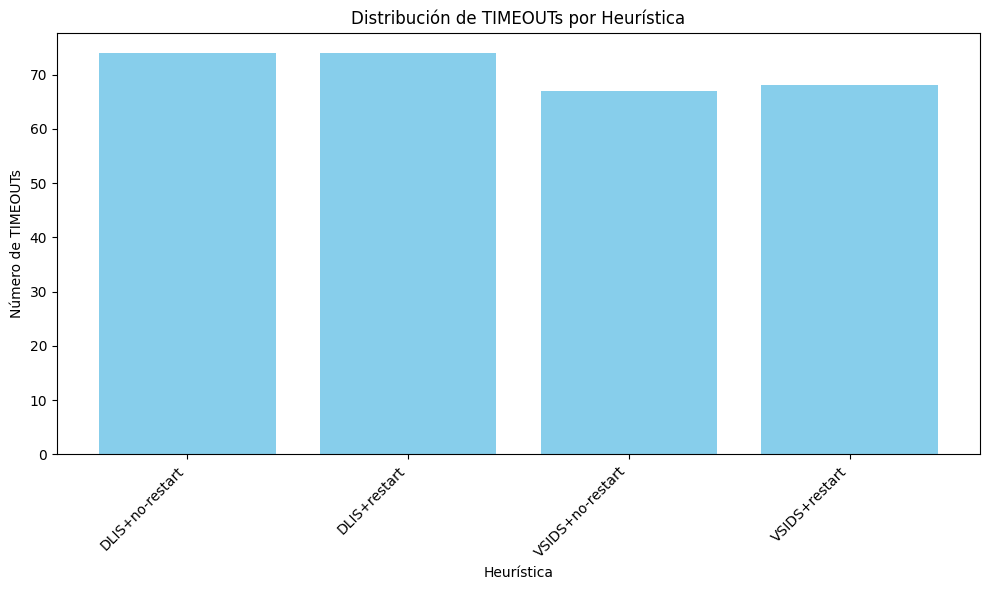

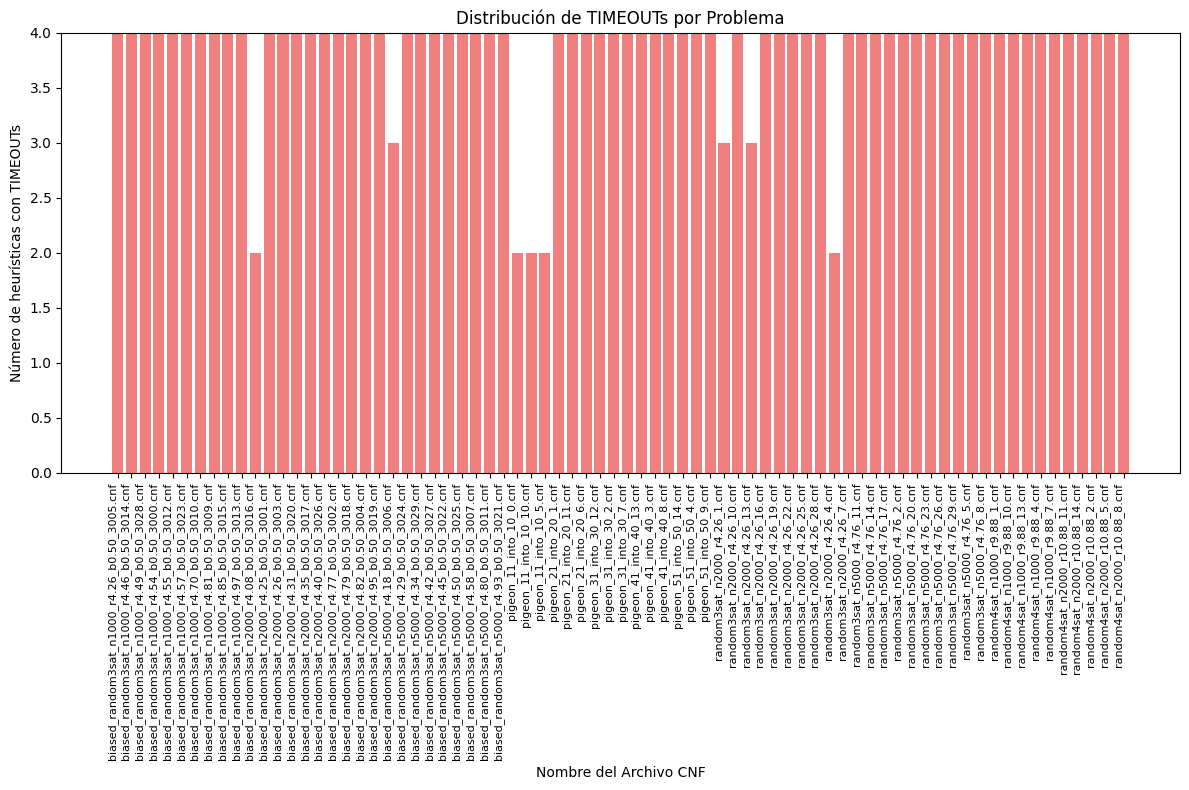

In [5]:
# Conteo por heurística
timeout_by_heur = df_timeout.groupby('heuristica').size().reset_index(name='count')
#print(timeout_by_heur)

# Conteo por problema
timeout_by_prob = df_timeout.groupby('nombre_cnf').size().reset_index(name='count')
#print(timeout_by_prob)

# 1. Histograma de TIMEOUT por heurística
plt.figure(figsize=(10, 6))  # Ajusta el tamaño según sea necesario
plt.bar(timeout_by_heur['heuristica'], timeout_by_heur['count'], color='skyblue')
plt.xlabel('Heurística')
plt.ylabel('Número de TIMEOUTs')
plt.title('Distribución de TIMEOUTs por Heurística')
plt.xticks(rotation=45, ha='right')  # Rota las etiquetas para mejor legibilidad
plt.tight_layout()  # Ajusta el layout para evitar cortes
plt.show()

# 2. Histograma de TIMEOUT por nombre de archivo CNF (problema)
plt.figure(figsize=(12, 8))  # Ajusta el tamaño según sea necesario
plt.bar(timeout_by_prob['nombre_cnf'], timeout_by_prob['count'], color='lightcoral')
plt.xlabel('Nombre del Archivo CNF')
plt.ylabel('Número de heurísticas con TIMEOUTs')
plt.title('Distribución de TIMEOUTs por Problema')
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rota y reduce el tamaño de las etiquetas
plt.ylim(0, 4)
plt.tight_layout()  # Ajusta el layout para evitar cortes
plt.show()


En las graficas se puede observar que los problemas que tomaron mas tiempo en resolverse coinciden con los los planteados en la literatura que resultan mas dificiles de resolver a instancias SAT. Respecto a la cantidad de problemas con TIMEOUTS por heuristica, se puede apreciar que DLIS, independientemente del restart, se comporta mas lento que vsids para algunos problemas. Por su parte, vsids con restart se comporta mas lento que vsids sin restart para unas pocas instancias.

### Análisis de problemas resueltos (SATISFIABLE/UNSATISFIABLE)

In [6]:
# Filtrar problemas resueltos
df_solved = df[df['resultado'].isin(['SATISFIABLE', 'UNSATISFIABLE'])].copy()

# Seleccionar columnas relevantes
cols_solved = cols_timeout + ['tiempo_segundos']
df_solved = df_solved[cols_solved]

# Mostrar tabla resumen
display(df_solved)


,nombre_cnf,heuristica,num_vars,num_clausulas,densidad,tamanio_prom_clausula,vars_positivas,vars_negativas,tiempo_segundos
0,bmc_flipflop_d5_6.cnf,VSIDS+restart,6,12,2.00,1.833333,6,6,0.001393
1,bmc_flipflop_d5_6.cnf,VSIDS+no-restart,6,12,2.00,1.833333,6,6,0.001926
2,bmc_flipflop_d5_6.cnf,DLIS+restart,6,12,2.00,1.833333,6,6,0.001446
3,bmc_flipflop_d5_6.cnf,DLIS+no-restart,6,12,2.00,1.833333,6,6,0.001656
8,bmc_flipflop_d11_14.cnf,VSIDS+restart,12,24,2.00,1.916667,12,12,0.001496
...,...,...,...,...,...,...,...,...,...
634,random4sat_n500_r8.88_6.cnf,DLIS+no-restart,500,4440,8.88,4.000000,500,500,9.077070
635,parity_n50_14.cnf,VSIDS+restart,50,1226,24.52,2.039152,50,50,0.001582
636,parity_n50_14.cnf,VSIDS+no-restart,50,1226,24.52,2.039152,50,50,0.001382
637,parity_n50_14.cnf,DLIS+restart,50,1226,24.52,2.039152,50,50,0.001617


El análisis de los problemas resueltos muestra que las instancias que concluyeron satisfactoriamente (ya sea SATISFIABLE o UNSATISFIABLE) abarcan un amplio rango de tamaños y características, desde problemas muy pequeños con 6 variables y 12 cláusulas hasta otros considerablemente más grandes con hasta 5000 variables y más de 23000 cláusulas. Los tiempos de resolución registrados varían notablemente, desde fracciones de segundo en problemas pequeños (por ejemplo, alrededor de 0.0014 segundos en instancias con 6 variables) hasta varios segundos en problemas más complejos (por ejemplo, cerca de 9 segundos en instancias con 500 variables y alta densidad). Esto indica que, aunque el solver puede resolver eficientemente instancias pequeñas o medianas, el tiempo de cómputo crece conforme aumentan la cantidad de variables y cláusulas, así como la densidad del problema. La presencia de las cuatro heurísticas en los resultados resueltos sugiere que todas son capaces de resolver ciertos conjuntos de problemas. Sin embargo, la diversidad en tiempos y tamaños sugiere que la heurística y la estrategia de reinicio podrían influir en la eficiencia, especialmente en problemas de mayor escala. 

In [7]:
# Estadísticas descriptivas del tiempo de resolución por heurística y característica del problema
solved_stats = df_solved.groupby('heuristica')[cols_solved].describe().T
display(solved_stats)


heuristica                   DLIS+no-restart  DLIS+restart  VSIDS+no-restart  \
num_vars              count        85.000000     86.000000         93.000000   
                      mean        322.000000    322.906977        388.172043   
                      std         339.369864    337.472496        474.007765   
                      min           4.000000      4.000000          4.000000   
                      25%          30.000000     30.000000         30.000000   
                      50%         200.000000    250.000000        300.000000   
                      75%         400.000000    400.000000        400.000000   
                      max        1000.000000   1000.000000       2000.000000   
num_clausulas         count        85.000000     86.000000         93.000000   
                      mean       3135.388235   3178.325581       3319.688172   
                      std        9475.052621   9427.564774       9138.870466   
                      min           8.000000      8.000000          8.000000   
                      25%         436.000000    436.000000        436.000000   
                      50%         778.000000    779.500000        781.000000   
                      75%        1264.000000   3136.000000       3760.000000   
                      max       51920.000000  51920.000000      51920.000000   
densidad              count        85.000000     86.000000         93.000000   
                      mean          7.277965      7.391826          7.181215   
                      std          10.270768     10.264627          9.895031   
                      min           2.000000      2.000000          2.000000   
                      25%           2.255000      2.266250          2.406667   
                      50%           3.366667      3.393333          3.733333   
                      75%           8.880000      8.880000          5.100000   
                      max          51.920000     51.920000         51.920000   
tamanio_prom_clausula count        85.000000     86.000000         93.000000   
                      mean          3.465057      3.448362          3.387416   
                      std           1.607643      1.605640          1.562465   
                      min           1.750000      1.750000          1.750000   
                      25%           2.039152      2.039152          2.039152   
                      50%           3.000000      3.000000          3.000000   
                      75%           5.000000      5.000000          5.000000   
                      max           6.000000      6.000000          6.000000   
vars_positivas        count        85.000000     86.000000         93.000000   
                      mean        321.529412    322.441860        387.559140   
                      std         338.493497    336.602842        472.867351   
                      min           4.000000      4.000000          4.000000   
                      25%          30.000000     30.000000         30.000000   
                      50%         200.000000    249.500000        299.000000   
                      75%         400.000000    400.000000        400.000000   
                      max        1000.000000   1000.000000       1998.000000   
vars_negativas        count        85.000000     86.000000         93.000000   
                      mean        318.611765    319.558140        384.935484   
                      std         338.518273    336.635520        473.408657   
                      min           4.000000      4.000000          4.000000   
                      25%          30.000000     30.000000         30.000000   
                      50%         200.000000    238.500000        277.000000   
                      75%         399.000000    399.750000        400.000000   
                      max        1000.000000   1000.000000       1999.000000   
tiempo_segundos       count        55.000000     49.000000         63.000000   


El análisis estadístico descriptivo del tiempo de resolución y las características de las instancias resueltas por cada heurística revela patrones importantes sobre el comportamiento del solver. En primer lugar, se observa que las instancias resueltas por las cuatro heurísticas (DLIS+no-restart, DLIS+restart, VSIDS+no-restart y VSIDS+restart) cubren un rango amplio en tamaño, con número de variables promedio entre 322 y 403, y máximos que alcanzan hasta 2000 o incluso 5000 variables en el caso de VSIDS+restart. La cantidad de cláusulas también presenta gran dispersión, con medias cercanas a 3100–3400 y máximos que superan las 50,000, lo que indica que el solver puede manejar problemas desde muy pequeños hasta instancias complejas. La densidad promedio se mantiene alrededor de 7,2 a 7,4, con valores máximos muy altos (hasta 51.9), reflejando diversidad en la estructura de los problemas. En cuanto al tiempo de resolución, se evidencia una marcada diferencia entre heurísticas: DLIS+no-restart presenta el tiempo medio más bajo (~0.37 s), seguido por DLIS+restart (~3.13 s), mientras que VSIDS+no-restart y VSIDS+restart muestran tiempos medios más elevados, cerca de 4.98 y 4.98 segundos respectivamente, con alta variabilidad (desviaciones estándar muy grandes y máximos que superan los 80 segundos). Esta dispersión sugiere que aunque VSIDS puede ser eficiente en muchos casos, también enfrenta problemas que requieren tiempos significativamente mayores. Además, la mediana del tiempo para todas las heurísticas es muy baja (en el orden de milisegundos), indicando que la mayoría de las instancias se resuelven rápidamente, pero existen casos atípicos que prolongan el tiempo promedio. El tamaño promedio de cláusula es similar entre heurísticas, alrededor de 3.4, y las variables positivas y negativas mantienen valores simétricos, lo que indica que estas características no explican las diferencias en tiempo. En conjunto, estos resultados sugieren que la elección de heurística impacta significativamente el tiempo de resolución en ciertos problemas, especialmente en instancias grandes o complejas, y que VSIDS puede tener mayor variabilidad en rendimiento. 

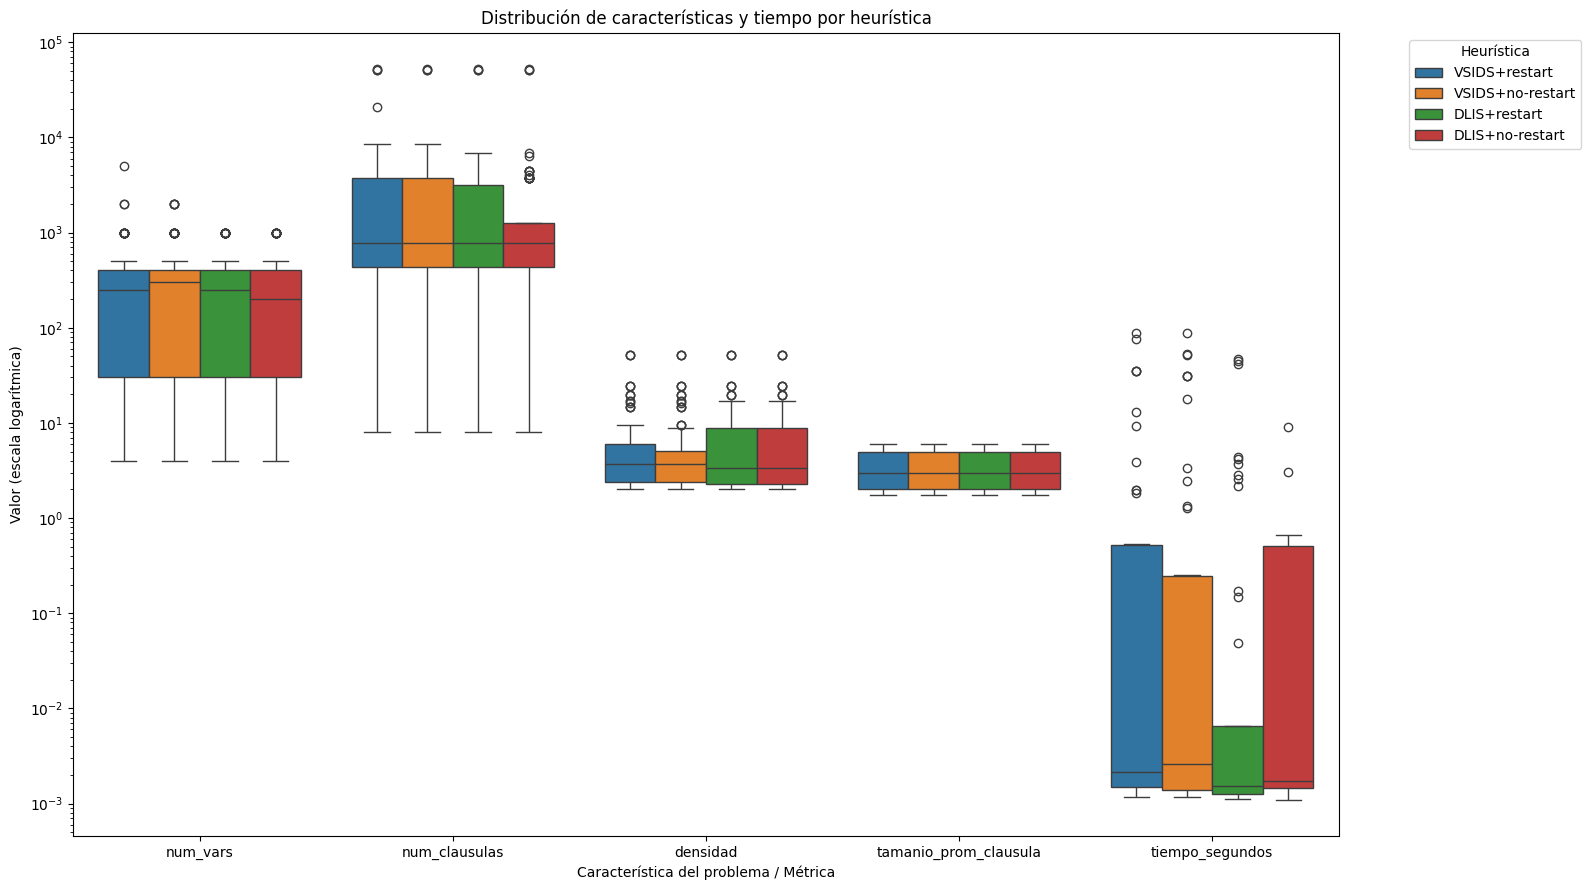

In [8]:
# Variables a graficar, incluyendo vars_positivas y vars_negativas
cols_solved = [
    'num_vars', 'num_clausulas', 'densidad', 'tamanio_prom_clausula',
    'tiempo_segundos'
]

# Convertir a formato largo para seaborn
df_melt = pd.melt(df_solved, id_vars=['heuristica'], value_vars=cols_solved,
                  var_name='Característica', value_name='Valor')

# Graficar boxplots agrupados por heurística y variable
plt.figure(figsize=(16,9))
sns.boxplot(x='Característica', y='Valor', hue='heuristica', data=df_melt)

# Escala logarítmica para variables con alta dispersión (tiempo)
plt.yscale('log')

plt.title('Distribución de características y tiempo por heurística')
plt.xlabel('Característica del problema / Métrica')
plt.ylabel('Valor (escala logarítmica)')
plt.legend(title='Heurística', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Análisis problemas resueltos vs TIMEOUT

#### Matriz de correlación

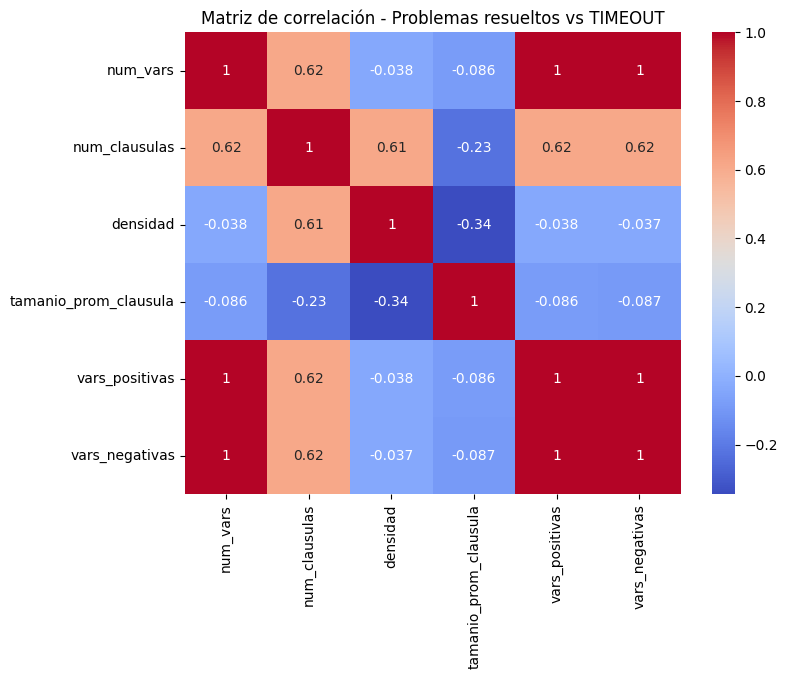

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(df_filtered[caracteristicas].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación - Problemas resueltos vs TIMEOUT')
plt.show()

#### Interpretación de las correlaciones observadas

##### 1. Correlaciones perfectas (r = 1):

- num_vars y num_clausulas están perfectamente correlacionados.

- vars_positivas y vars_negativas también tienen correlación perfecta.

- Además, vars_positivas y vars_negativas están perfectamente correlacionadas con num_vars.

Esto indica que estas variables son redundantes y aportan la misma información.

##### 2. Correlaciones moderadas (r ≈ 0.48):

- tamanio_prom_clausula con vars_negativas, vars_positivas, num_vars y num_clausulas.

Esto indica cierta relación, pero no es tan fuerte como para ser redundante inmediata.

##### 3. Correlaciones bajas o nulas (|r| < 0.05):

- densidad con num_clausulas, num_vars, vars_positivas y vars_negativas.

- tamanio_prom_clausula con densidad (r = -0.29).

Esto indica que densidad aporta información diferente y no está correlacionada con las otras variables.

**Eeliminar multicolinealidad**

*Eliminar variables redundantes con correlación perfecta:*

- Mantener solo una variable representativa del grupo altamente correlacionado. Por ejemplo, conservar num_vars y eliminar num_clausulas, vars_positivas y vars_negativas.


*Mantener variables con correlación moderada o baja:*

- tamanio_prom_clausula y densidad son variables informativas que aportan información distinta y deben conservarse.


### Selección de variables para eliminar multicolinealidad severa

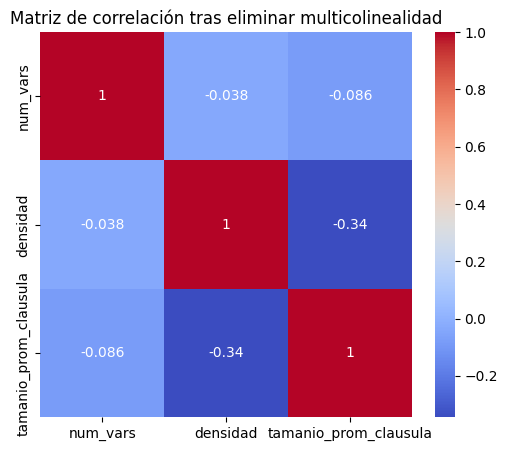

In [26]:
# Según correlaciones perfectas, conservar solo estas variables:
caracteristicas_reducidas = ['num_vars', 'densidad', 'tamanio_prom_clausula']

#  Mostrar matriz de correlación con variables seleccionadas
plt.figure(figsize=(6,5))
sns.heatmap(df_filtered[caracteristicas_reducidas].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación tras eliminar multicolinealidad')
plt.show()

### Calcular Factor de Inflación de la Varianza (VIF) para variables reducidas y confirmar

In [27]:
X_reducido = df_filtered[caracteristicas_reducidas]
vif_data_reducido = pd.DataFrame()
vif_data_reducido['feature'] = X_reducido.columns
vif_data_reducido['VIF'] = [variance_inflation_factor(X_reducido.values, i) for i in range(X_reducido.shape[1])]
print("VIF después de eliminar variables redundantes:")
print(vif_data_reducido)

VIF después de eliminar variables redundantes:
                 feature       VIF
0               num_vars  1.520931
1               densidad  1.413404
2  tamanio_prom_clausula  1.759798


#### Interpretación basada en los valores VIF

Según las referencias y definiciones estándar del Factor de Inflación de la Varianza (VIF):

- VIF = 1 indica ausencia total de multicolinealidad.

- VIF entre 1 y 5 indica una multicolinealidad moderada, que usualmente no representa un problema grave para la estabilidad o interpretación del modelo.

- VIF > 5 sugiere multicolinealidad alta, que puede inflar la varianza de los coeficientes y dificultar su interpretación.

- VIF > 10 indica multicolinealidad grave, que requiere acciones correctivas.


### Pruebas estadísticas: Características y TIMEOUT
#### a) Comparación de características entre TIMEOUT y NO-TIMEOUT


In [12]:
# Variables seleccionadas sin multicolinealidad
caracteristicas_reducidas = ['num_vars', 'densidad', 'tamanio_prom_clausula']

# Crear variable binaria: 1 = TIMEOUT, 0 = resuelto
df['is_timeout'] = (df['resultado'] == 'TIMEOUT').astype(int)

# Filtrar filas válidas (sin NaN en características)
df_valid = df.dropna(subset=caracteristicas_reducidas + ['is_timeout'])

# Prueba de normalidad para cada característica
for col in caracteristicas_reducidas:
    print(f"{col} (TIMEOUT):", stats.shapiro(df_valid[df_valid['is_timeout']==1][col]))
    print(f"{col} (NO TIMEOUT):", stats.shapiro(df_valid[df_valid['is_timeout']==0][col]))



num_vars (TIMEOUT): ShapiroResult(statistic=np.float64(0.7933191376191727), pvalue=np.float64(1.1794648547679767e-18))
num_vars (NO TIMEOUT): ShapiroResult(statistic=np.float64(0.6698142994834743), pvalue=np.float64(9.428437191286474e-26))
densidad (TIMEOUT): ShapiroResult(statistic=np.float64(0.6461253813664019), pvalue=np.float64(7.820027948180053e-24))
densidad (NO TIMEOUT): ShapiroResult(statistic=np.float64(0.5441281055563653), pvalue=np.float64(2.297890446301959e-29))
tamanio_prom_clausula (TIMEOUT): ShapiroResult(statistic=np.float64(0.752042266567243), pvalue=np.float64(2.4804046463422804e-20))
tamanio_prom_clausula (NO TIMEOUT): ShapiroResult(statistic=np.float64(0.8112114166434761), pvalue=np.float64(4.389991714803694e-20))


#### Interpretando los resultados de las pruebas de normalidad (Shapiro-Wilk)

El análisis de normalidad realizado mediante la prueba de Shapiro-Wilk para las variables seleccionadas sin multicolinealidad —número de variables, densidad y tamaño promedio de cláusula— revela que ninguna de estas características sigue una distribución normal en los grupos de instancias que terminaron en TIMEOUT ni en las que fueron resueltas. Esto se evidencia en los valores de p muy bajos (todos menores a 0.05, incluso extremadamente cercanos a cero), lo que permite rechazar la hipótesis nula de normalidad para cada variable en ambos grupos. En concreto, los estadísticos de Shapiro oscilan entre aproximadamente 0.54 y 0.81, y los p-valores indican una desviación significativa de la normalidad. Este resultado implica que para comparar estas características entre instancias con y sin TIMEOUT no es apropiado utilizar pruebas paramétricas basadas en la normalidad, como el t-test, sino que se deben emplear métodos no paramétricos, por ejemplo la prueba de Mann-Whitney o Kruskal-Wallis, que no requieren supuestos de distribución. Además, la ausencia de normalidad sugiere que las distribuciones de estas variables pueden ser sesgadas o contener valores atípicos, lo cual es coherente con la gran dispersión observada en análisis previos. 


In [13]:
# Prueba Mann-Whitney U (no paramétrica)
for col in caracteristicas_reducidas:
    stat, p = stats.mannwhitneyu(
        df_valid[df_valid['is_timeout']==1][col],
        df_valid[df_valid['is_timeout']==0][col],
        alternative='two-sided'
    )
    print(f"Mann-Whitney U para {col}: p-value = {p:.4g}")

Mann-Whitney U para num_vars: p-value = 1.383e-83
Mann-Whitney U para densidad: p-value = 3.168e-29
Mann-Whitney U para tamanio_prom_clausula: p-value = 0.803


#### Interpretando los resultados de las pruebas Mann-Whitney U (comparación entre TIMEOUT y NO-TIMEOUT)

La prueba no paramétrica de Mann-Whitney U aplicada a las variables seleccionadas muestra resultados concluyentes sobre las diferencias entre las instancias que terminaron en TIMEOUT y las que fueron resueltas. Para las variables número de variables y densidad, los valores p son extremadamente bajos (1.383e-83 y 3.168e-29 respectivamente), lo que indica diferencias estadísticamente significativas entre ambos grupos en estas características. Esto sugiere que tanto el tamaño del problema como su densidad influyen fuertemente en la probabilidad de que un problema termine en TIMEOUT. En contraste, para el tamaño promedio de cláusula el p-valor es alto (0.803), lo que implica que no hay evidencia suficiente para afirmar que esta característica difiera entre problemas con y sin TIMEOUT. Estos resultados confirman que las variables relacionadas con la escala y complejidad estructural del problema (num_vars y densidad) son factores determinantes en el rendimiento del solver, mientras que el tamaño promedio de las cláusulas no parece ser un factor discriminante en la ocurrencia de TIMEOUT. En consecuencia, para modelar o predecir la probabilidad de TIMEOUT conviene priorizar las variables num_vars y densidad, y descartar o tratar con menor peso el tamaño promedio de cláusula. 

#### Visualizando el resultado anterior

is_timeout                             0            1
num_vars              count   356.000000   283.000000
                      mean    360.505618  2438.657244
                      std     466.438798  1631.753277
                      min       4.000000   110.000000
                      25%      30.000000  1000.000000
                      50%     250.000000  2000.000000
                      75%     400.000000  5000.000000
                      max    5000.000000  5000.000000
densidad              count   356.000000   283.000000
                      mean      7.263162     7.580536
                      std      10.045922     5.447169
                      min       2.000000     4.076000
                      25%       2.300000     4.399500
                      50%       3.490000     4.760000
                      75%       8.880000     9.880000
                      max      51.920000    25.020000
tamanio_prom_clausula count   356.000000   283.000000
                      mean      3.421765     2.963924
                      std       1.579532     0.553472
                      min       1.750000     2.038369
                      25%       2.039152     3.000000
                      50%       3.000000     3.000000
                      75%       5.000000     3.000000
                      max       6.000000     4.000000

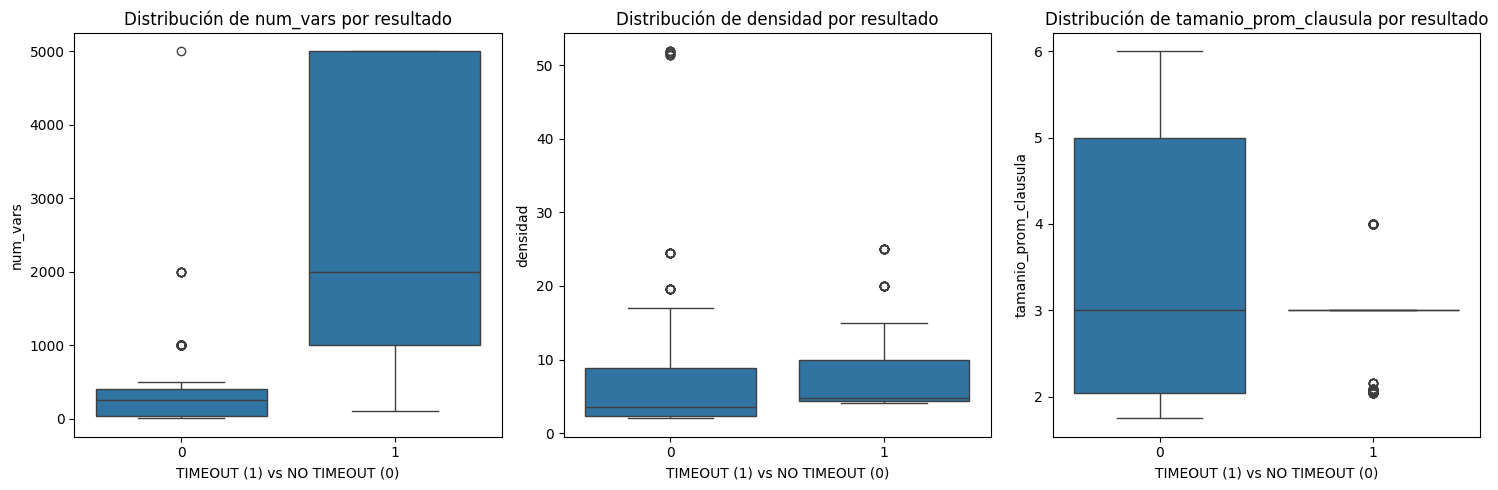

In [28]:
# Variables seleccionadas
caracteristicas_reducidas = ['num_vars', 'densidad', 'tamanio_prom_clausula']

# Crear tabla con estadísticas descriptivas agrupadas por 'is_timeout'
stats_table = df_valid.groupby('is_timeout')[caracteristicas_reducidas].describe().T

# Mostrar tabla con formato legible
display(stats_table)

# Crear figura con subplots para cada variable
plt.figure(figsize=(15, 5))

for i, var in enumerate(caracteristicas_reducidas, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='is_timeout', y=var, data=df_valid)
    plt.xlabel('TIMEOUT (1) vs NO TIMEOUT (0)')
    plt.title(f'Distribución de {var} por resultado')
    plt.tight_layout()

plt.show()


#### Interpretación
El análisis descriptivo agrupado por la variable binaria is_timeout revela diferencias claras y relevantes entre las instancias que terminaron en TIMEOUT (1) y las que fueron resueltas (0), en relación con las características seleccionadas. En primer lugar, el número de variables presenta una diferencia notable: las instancias con TIMEOUT tienen un promedio muy superior (2438.7) frente a las resueltas (360.5), con una dispersión amplia en ambos grupos, lo que indica que problemas más grandes tienden a no resolverse en el tiempo límite. La mediana (50%) también refleja esta tendencia, siendo 2000 para TIMEOUT y 250 para NO TIMEOUT, confirmando que la mayoría de los problemas que fallan son considerablemente más grandes. En cuanto a la densidad, aunque la diferencia media es menor (7.58 para TIMEOUT vs. 7.26 para NO TIMEOUT), la mediana y los percentiles superiores también sugieren que las instancias con TIMEOUT suelen ser un poco más densas, lo que puede incrementar la complejidad del problema. Por último, el tamaño promedio de cláusula muestra un comportamiento inverso: es menor en los casos con TIMEOUT (media 2.96) que en los resueltos (media 3.42), y la mediana para TIMEOUT se mantiene en 3 mientras que para NO TIMEOUT es también 3 pero con mayor dispersión hacia valores mayores. Esto indica que el tamaño de las cláusulas no es un factor que incremente la probabilidad de TIMEOUT, e incluso podría estar asociado a problemas más simples en términos de cláusulas. En conjunto, estos resultados apuntan a que el factor predominante para que un problema no se resuelva en el tiempo asignado es su tamaño (número de variables) y en menor medida su densidad, mientras que el tamaño de cláusula no parece ser determinante. 

#### b) Regresión logística: ¿Qué características predicen TIMEOUT?


In [15]:
X = df_valid[caracteristicas_reducidas]
y = df_valid['is_timeout']

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X, y)

for name, coef in zip(caracteristicas_reducidas, logreg.coef_[0]):
    print(f"{name}: coeficiente logit = {coef:.4f}")


num_vars: coeficiente logit = 0.0032
densidad: coeficiente logit = -0.0314
tamanio_prom_clausula: coeficiente logit = -0.5455


#### Interpretación de los resultados

El modelo de regresión logística ajustado para predecir la ocurrencia de TIMEOUT a partir de las variables seleccionadas ofrece una interpretación clara sobre la influencia de cada característica en la probabilidad de que un problema no se resuelva en el tiempo límite. El coeficiente positivo para num_vars (0.0032) indica que a medida que aumenta el número de variables, la probabilidad de TIMEOUT también incrementa, lo cual es consistente con la intuición y los análisis descriptivos previos que mostraron que problemas más grandes tienden a ser más difíciles de resolver. Por otro lado, los coeficientes negativos para densidad (-0.0314) y especialmente para tamaño promedio de cláusula (-0.5455) sugieren que, manteniendo constante el número de variables, un aumento en estas características está asociado con una menor probabilidad de TIMEOUT. En particular, el tamaño promedio de cláusula tiene un efecto considerablemente más fuerte en sentido negativo, lo que podría indicar que cláusulas más largas o complejas, dentro del rango observado, facilitan la resolución o están asociadas a problemas menos propensos a agotar el tiempo. Estos signos y magnitudes reflejan que la complejidad estructural del problema no se reduce solo al tamaño, sino que la forma en que las cláusulas están construidas también impacta el rendimiento del solver. En conjunto, el modelo confirma y cuantifica las tendencias observadas en análisis estadísticos previos, y ofrece una base para predecir y ajustar heurísticas en función de las características del problema para minimizar la ocurrencia de TIMEOUT.


## Analisis del rendimiento de las heuristicas en problemas resueltos

#### Correlación entre características y tiempo de resolución


In [16]:
# Filtrar solo problemas resueltos y sin NaN en variables seleccionadas y tiempo
df_solved_reduced = df[
    df['resultado'].isin(['SATISFIABLE', 'UNSATISFIABLE'])
].dropna(subset=caracteristicas_reducidas + ['tiempo_segundos', 'heuristica']).copy()

# Correlación de Spearman
for col in caracteristicas_reducidas:
    corr, p = stats.spearmanr(df_solved_reduced[col], df_solved_reduced['tiempo_segundos'])
    print(f"Spearman {col} vs tiempo_segundos: rho = {corr:.3f}, p = {p:.4g}")


Spearman num_vars vs tiempo_segundos: rho = 0.845, p = 1.116e-63
Spearman densidad vs tiempo_segundos: rho = 0.318, p = 8.968e-07
Spearman tamanio_prom_clausula vs tiempo_segundos: rho = 0.710, p = 1.929e-36


#### Interpretación basada en la correlación de Spearman

El análisis de correlación de Spearman entre las características seleccionadas y el tiempo de resolución en problemas resueltos revela asociaciones significativas y de distinta intensidad. La variable número de variables muestra una correlación muy fuerte y positiva con el tiempo de resolución (rho = 0.845, p ≪ 0.001), indicando que a mayor tamaño del problema, mayor es el tiempo requerido para resolverlo, lo cual es coherente con la complejidad esperada en problemas SAT. La densidad presenta una correlación positiva moderada (rho = 0.318, p ≪ 0.001), lo que sugiere que problemas con mayor densidad de cláusulas por variable tienden a requerir más tiempo, aunque este efecto es menos pronunciado que el del tamaño. Por último, el tamaño promedio de cláusula también exhibe una correlación fuerte positiva (rho = 0.710, p ≪ 0.001), indicando que cláusulas más largas o complejas están asociadas con un aumento significativo en el tiempo de resolución. Estos resultados confirman que tanto la escala del problema como su estructura influyen en el rendimiento del solver, siendo el número de variables el factor más determinante, seguido por la complejidad de las cláusulas y la densidad. 


#### Kruskal-Wallis: ¿El tiempo difiere entre heurísticas para un mismo tipo de problema?


In [17]:

# Asegúrate de tener la variable transformada log_tiempo
df_solved_reduced['log_tiempo'] = np.log1p(df_solved_reduced['tiempo_segundos'])

for heuristica in df_solved_reduced['heuristica'].unique():
    print(f"\nKruskal-Wallis para heurística: {heuristica}")
    df_h = df_solved_reduced[df_solved_reduced['heuristica'] == heuristica]
    
    for var in caracteristicas_reducidas:
        grupos = [grupo['log_tiempo'].values for nombre, grupo in df_h.groupby(var)]
        if len(grupos) > 1:
            stat, p = stats.kruskal(*grupos)
            print(f"Variable: {var}, estadístico = {stat:.4f}, p-valor = {p:.4g}")
        else:
            print(f"Variable: {var}, no hay suficientes grupos para test")



Kruskal-Wallis para heurística: VSIDS+restart
Variable: num_vars, estadístico = 55.0704, p-valor = 1.738e-06
Variable: densidad, estadístico = 55.8711, p-valor = 8.922e-05
Variable: tamanio_prom_clausula, estadístico = 54.8239, p-valor = 0.0001258

Kruskal-Wallis para heurística: VSIDS+no-restart
Variable: num_vars, estadístico = 54.7791, p-valor = 9.448e-07
Variable: densidad, estadístico = 55.2582, p-valor = 6.482e-05
Variable: tamanio_prom_clausula, estadístico = 55.6763, p-valor = 9.513e-05

Kruskal-Wallis para heurística: DLIS+restart
Variable: num_vars, estadístico = 41.2553, p-valor = 4.441e-05
Variable: densidad, estadístico = 40.6674, p-valor = 0.001692
Variable: tamanio_prom_clausula, estadístico = 42.9055, p-valor = 0.003232

Kruskal-Wallis para heurística: DLIS+no-restart
Variable: num_vars, estadístico = 46.9197, p-valor = 4.813e-06
Variable: densidad, estadístico = 47.8132, p-valor = 9.17e-05
Variable: tamanio_prom_clausula, estadístico = 48.7640, p-valor = 0.000332


### Interpretando los resultados

El análisis mediante la prueba no paramétrica de Kruskal-Wallis aplicado a la variable transformada del tiempo de resolución (logaritmo natural del tiempo más uno) para cada heurística y característica del problema revela diferencias estadísticamente significativas en todos los casos evaluados. Para las cuatro heurísticas (VSIDS+restart, VSIDS+no-restart, DLIS+restart y DLIS+no-restart), las variables número de variables, densidad y tamaño promedio de cláusula muestran valores de estadístico elevados y p-valores muy bajos (todos menores a 0.005), lo que indica que la distribución del tiempo de resolución difiere significativamente entre los distintos grupos definidos por cada una de estas características. Esto implica que, independientemente de la heurística utilizada, las propiedades estructurales del problema impactan de forma relevante en el rendimiento temporal del solver. La consistencia de estos resultados a través de todas las heurísticas sugiere que la influencia de estas variables es robusta y generalizable, reafirmando su importancia en el análisis y modelado del comportamiento del solver SAT. Además, el uso del logaritmo del tiempo como variable respuesta ayuda a mitigar la influencia de valores extremos y facilita la detección de diferencias significativas en la mediana y distribución del tiempo. 

### Pruebas post hoc con test de Dunn

In [18]:
for heuristica in df_solved_reduced['heuristica'].unique():
    print(f"\nTest de Dunn para heurística: {heuristica}")
    df_h = df_solved_reduced[df_solved_reduced['heuristica'] == heuristica].copy()
    
    for var in caracteristicas_reducidas:
        # Usar ranking para evitar bordes duplicados en qcut
        df_h.loc[:, 'grupo'] = pd.qcut(df_h[var].rank(method='first'), q=4, duplicates='drop')
        
        grupos = [grupo['log_tiempo'].values for nombre, grupo in df_h.groupby('grupo', observed=True)]
        
        if len(grupos) > 1:
            dunn_results = sp.posthoc_dunn(grupos, p_adjust='bonferroni')
            print(f"\nVariable: {var} (grupos por cuartiles con ranking)")
            print(dunn_results)
        else:
            print(f"Variable: {var}, no hay suficientes grupos para test")



Test de Dunn para heurística: VSIDS+restart

Variable: num_vars (grupos por cuartiles con ranking)
              1         2         3             4
1  1.000000e+00  0.703180  0.000015  1.056421e-07
2  7.031804e-01  1.000000  0.011745  4.209616e-04
3  1.466021e-05  0.011745  1.000000  1.000000e+00
4  1.056421e-07  0.000421  1.000000  1.000000e+00

Variable: densidad (grupos por cuartiles con ranking)
          1         2         3         4
1  1.000000  0.000007  0.000503  0.070783
2  0.000007  1.000000  1.000000  0.103465
3  0.000503  1.000000  1.000000  0.872152
4  0.070783  0.103465  0.872152  1.000000

Variable: tamanio_prom_clausula (grupos por cuartiles con ranking)
              1         2         3             4
1  1.000000e+00  0.123377  0.040784  7.498526e-08
2  1.233771e-01  1.000000  1.000000  6.133981e-03
3  4.078389e-02  1.000000  1.000000  2.285046e-02
4  7.498526e-08  0.006134  0.022850  1.000000e+00

Test de Dunn para heurística: VSIDS+no-restart

Variable: num_vars

### Interpretación general de los resultados

El test post-hoc de Dunn aplicado por cuartiles (grupos definidos con ranking para evitar empates) para cada heurística y variable seleccionada permite identificar con precisión entre qué grupos existen diferencias significativas en el tiempo de resolución (logaritmo del tiempo). En general, para la variable número de variables, se observan diferencias altamente significativas entre los cuartiles extremos (por ejemplo, grupo 1 vs. 4) en todas las heurísticas, con p-valores muy bajos (p < 0.001), lo que confirma que problemas más grandes requieren tiempos significativamente mayores para resolverse. En los grupos intermedios, las diferencias son menos consistentes pero también aparecen comparaciones significativas, evidenciando una relación gradual entre tamaño y tiempo. Para la densidad, los resultados muestran diferencias significativas principalmente entre los cuartiles más bajos y más altos, aunque en algunos casos los grupos intermedios no difieren tanto, indicando que la densidad afecta el tiempo pero con menor fuerza y de manera menos lineal que el tamaño. En cuanto al tamaño promedio de cláusula, también se detectan diferencias significativas entre los extremos, especialmente entre el primer y cuarto cuartil, y en varios casos entre grupos adyacentes, lo que sugiere que esta variable influye en el rendimiento, aunque su efecto puede ser más sutil o no monotónico. La consistencia de estos patrones a lo largo de todas las heurísticas refuerza la importancia de estas características para explicar la variabilidad en el tiempo de resolución. Este análisis detallado complementa y profundiza los resultados previos de Kruskal-Wallis, aportando información específica sobre qué rangos de las variables son responsables de las diferencias en rendimiento.

### Graficando los resultados anteriores

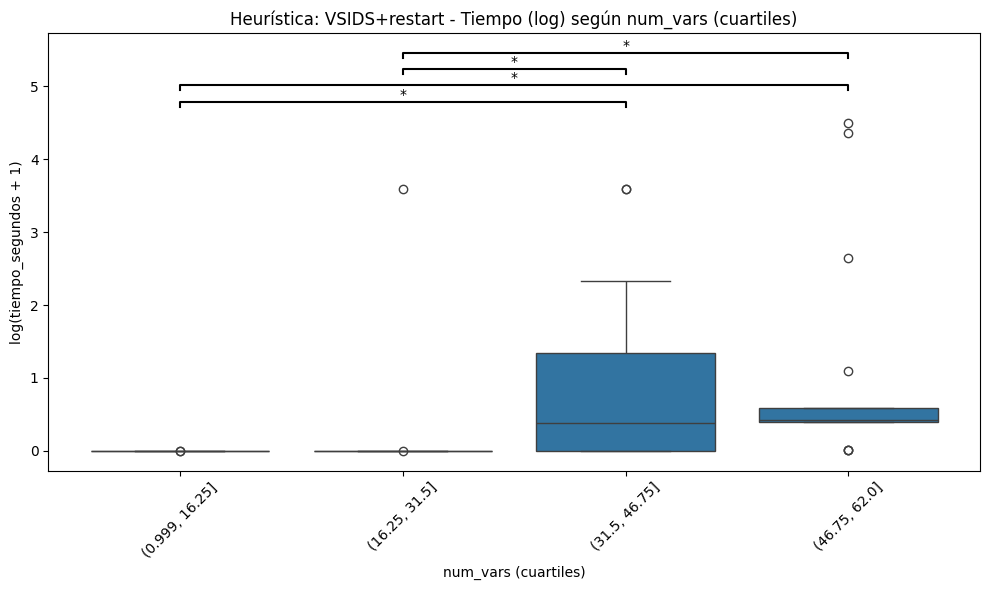

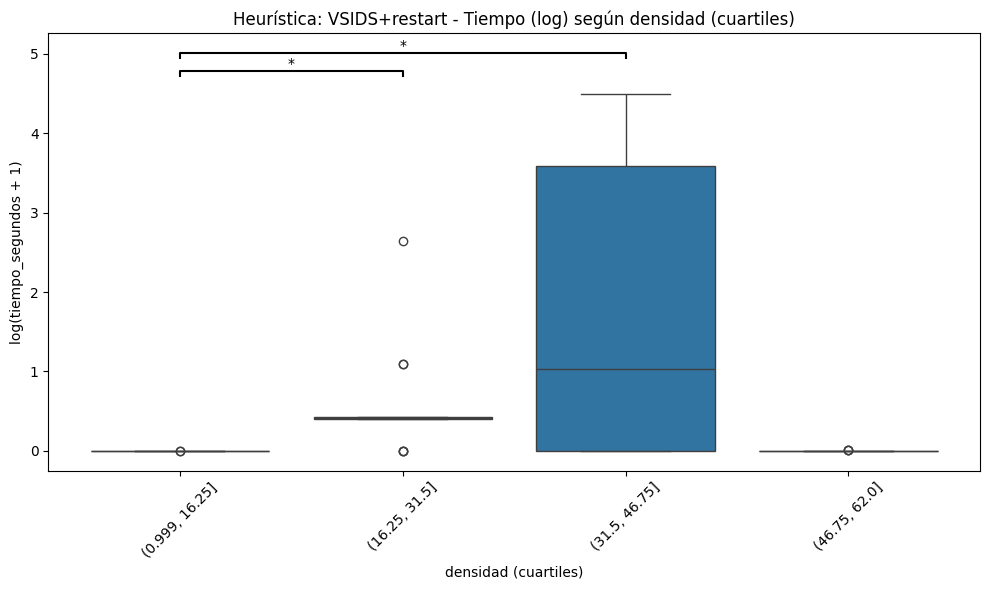

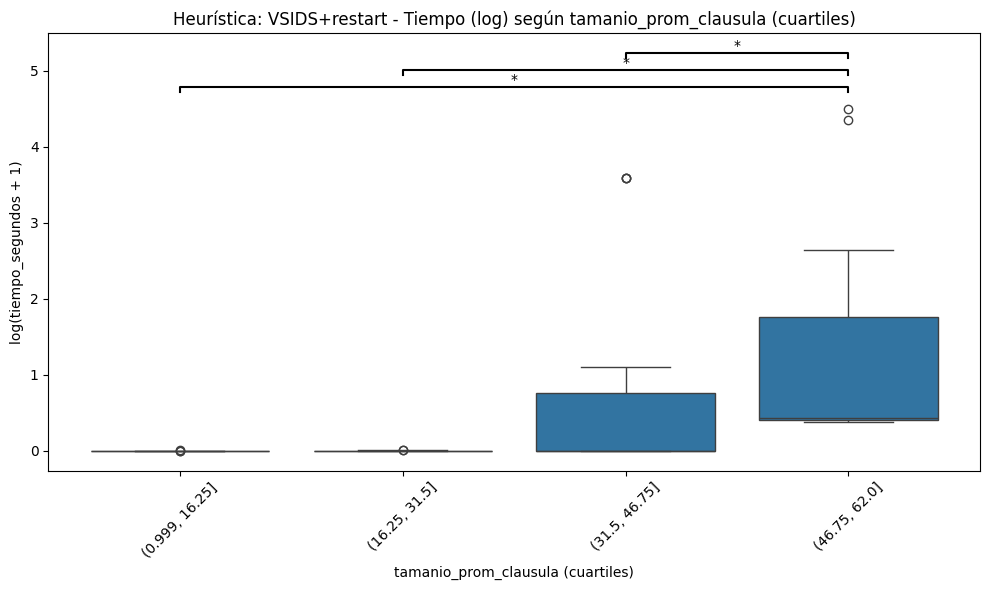

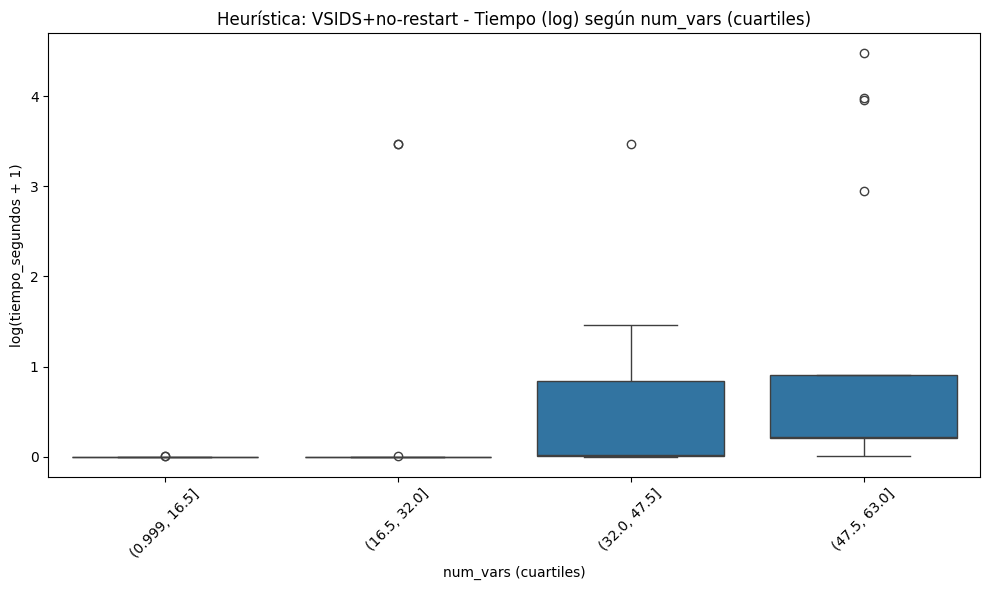

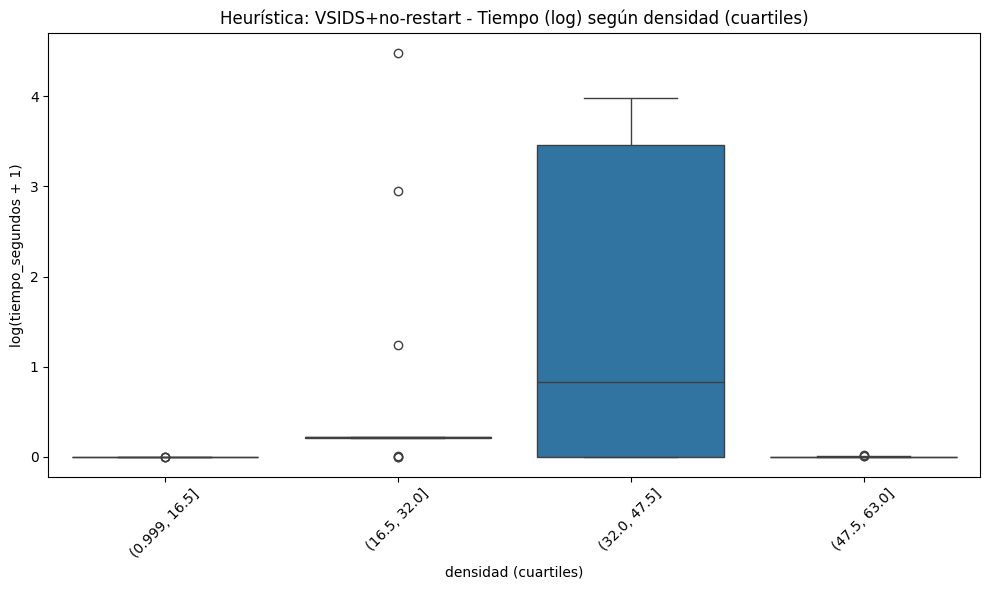

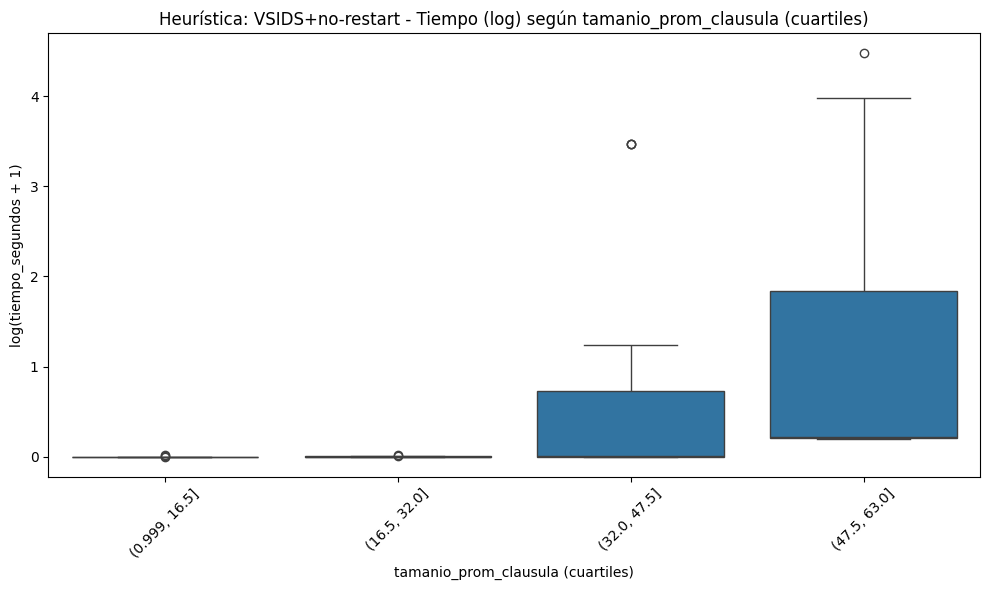

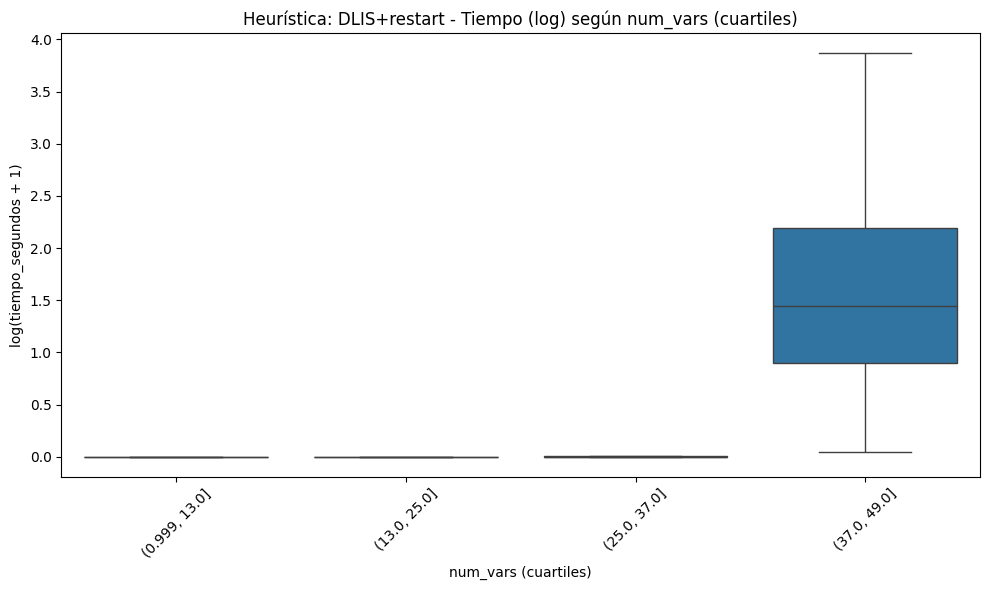

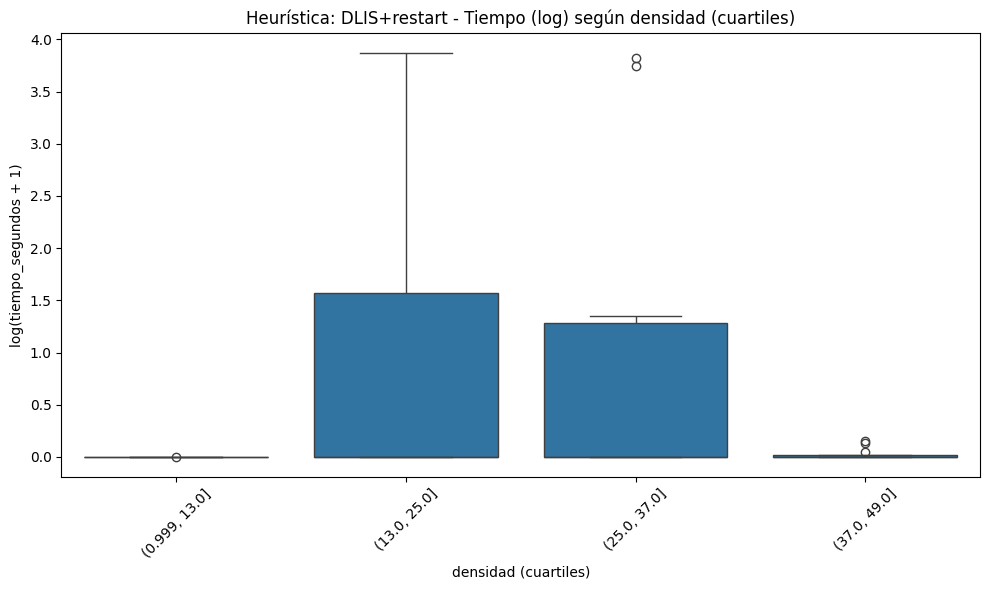

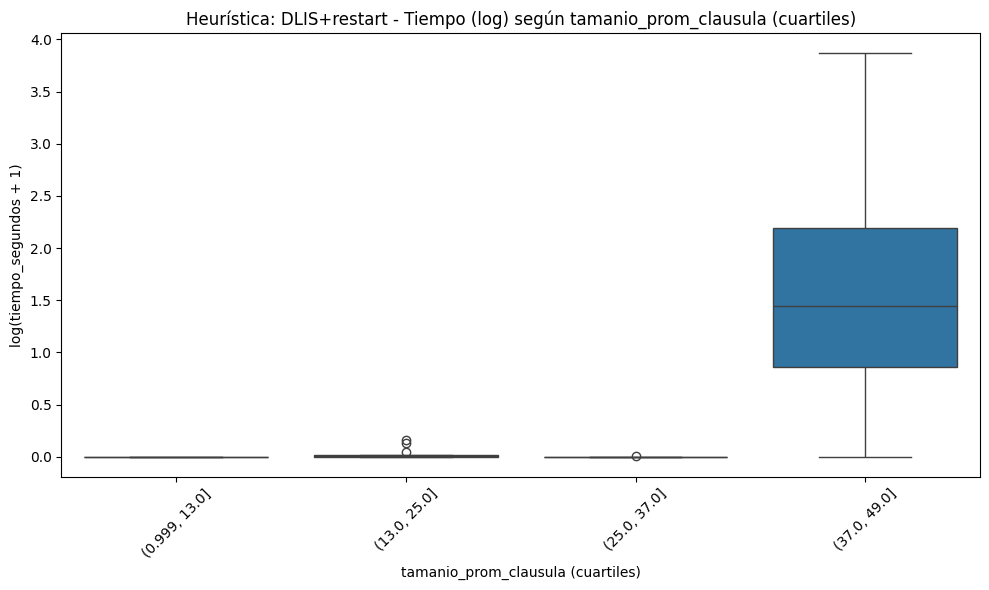

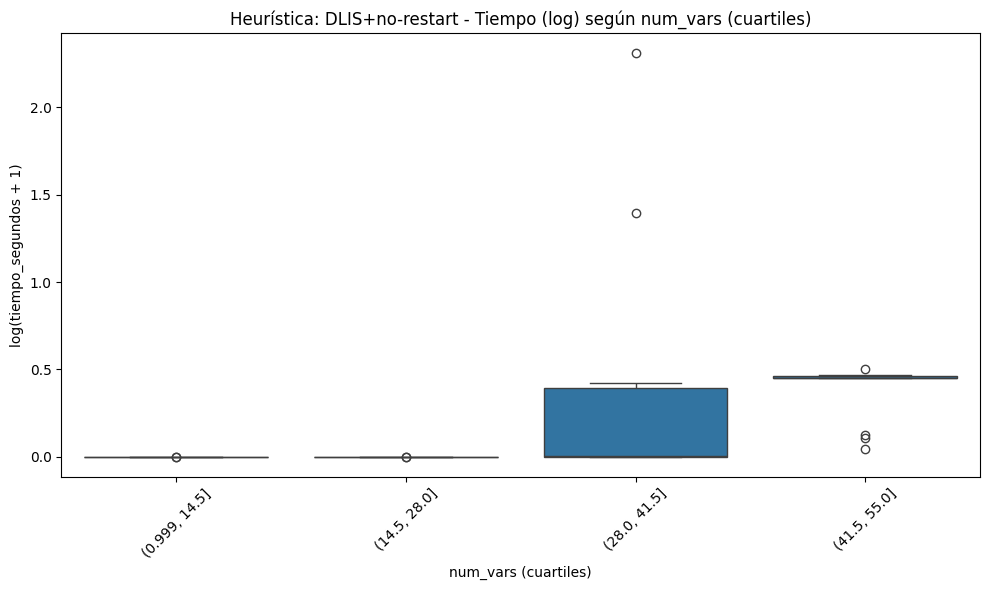

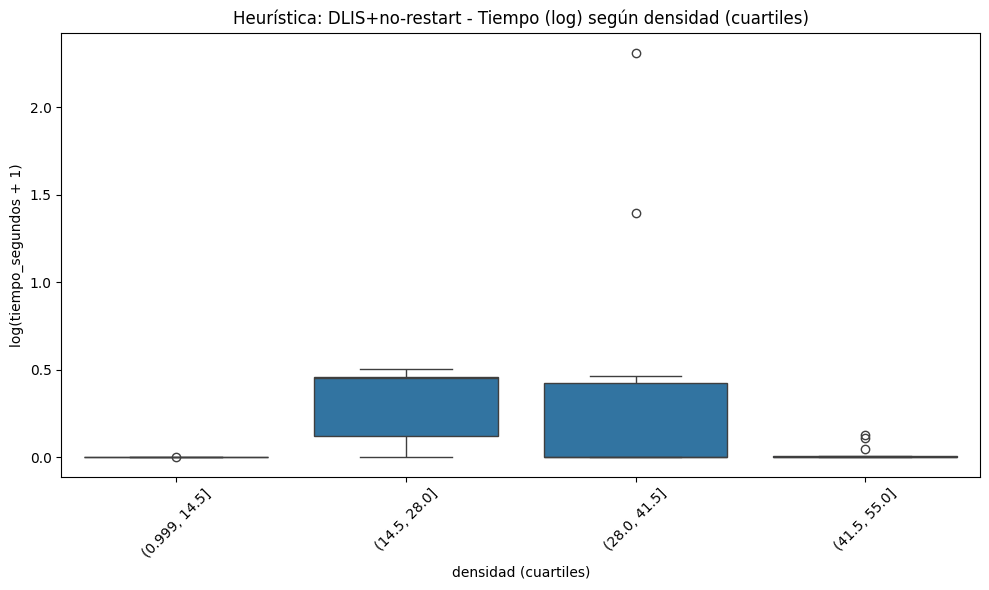

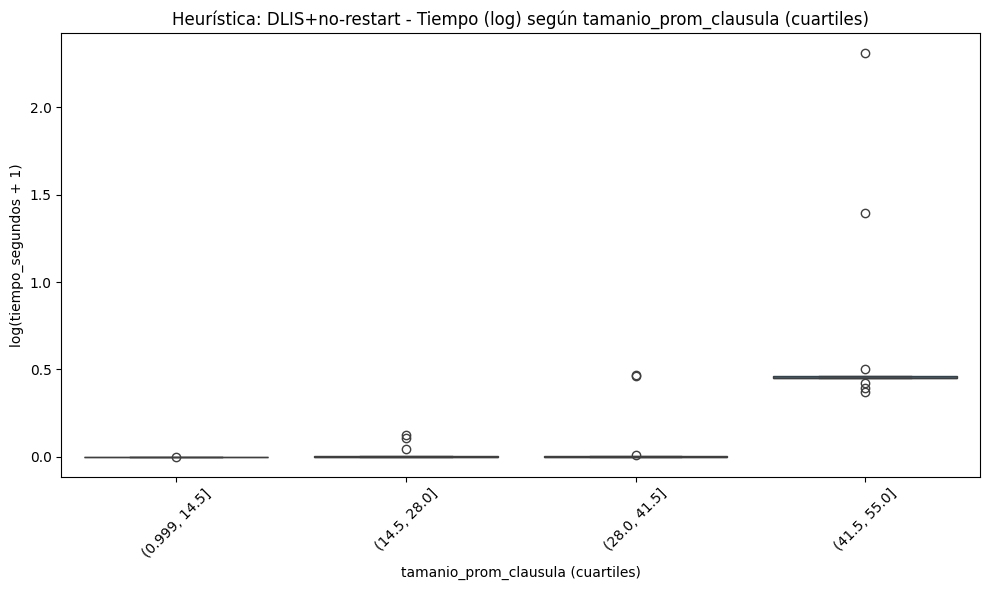

In [19]:
# Función para agregar líneas y asteriscos en comparaciones significativas
def add_stat_annotation(ax, group1, group2, y, h, text):
    x1, x2 = group1, group2
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color='k')

# Para cada heurística y variable, define los pares de grupos con p < 0.05

# Ejemplo simplificado para VSIDS+restart y variable num_vars
comparaciones_significativas = {
    'VSIDS+restart': {
        'num_vars': [(0, 2), (0, 3), (1, 2), (1, 3)],  # índices de grupos (0-based)
        'densidad': [(0, 1), (0, 2)],
        'tamanio_prom_clausula': [(0, 3), (1, 3), (2, 3)]
    },
    # Agrega las demás heurísticas y variables con sus pares significativos
}

for heuristica in df_solved_reduced['heuristica'].unique():
    df_h = df_solved_reduced[df_solved_reduced['heuristica'] == heuristica].copy()
    
    for var in caracteristicas_reducidas:
        # Discretizar variable en cuartiles con ranking para evitar warnings
        df_h.loc[:, 'grupo'] = pd.qcut(df_h[var].rank(method='first'), q=4, duplicates='drop')
        grupos_ordenados = sorted(df_h['grupo'].cat.categories)
        
        plt.figure(figsize=(10,6))
        ax = sns.boxplot(x='grupo', y='log_tiempo', data=df_h, order=grupos_ordenados)
        plt.title(f'Heurística: {heuristica} - Tiempo (log) según {var} (cuartiles)')
        plt.xlabel(f'{var} (cuartiles)')
        plt.ylabel('log(tiempo_segundos + 1)')
        plt.xticks(rotation=45)
        
        # Agregar anotaciones de comparaciones significativas si existen
        pares = comparaciones_significativas.get(heuristica, {}).get(var, [])
        y_max = df_h['log_tiempo'].max()
        h = (df_h['log_tiempo'].max() - df_h['log_tiempo'].min()) * 0.05  # altura para líneas
        
        for i, (g1, g2) in enumerate(pares):
            y = y_max + h * (i+1)
            add_stat_annotation(ax, g1, g2, y, h*0.3, '*')
        
        plt.tight_layout()
        plt.show()


### Visualización con boxplots

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


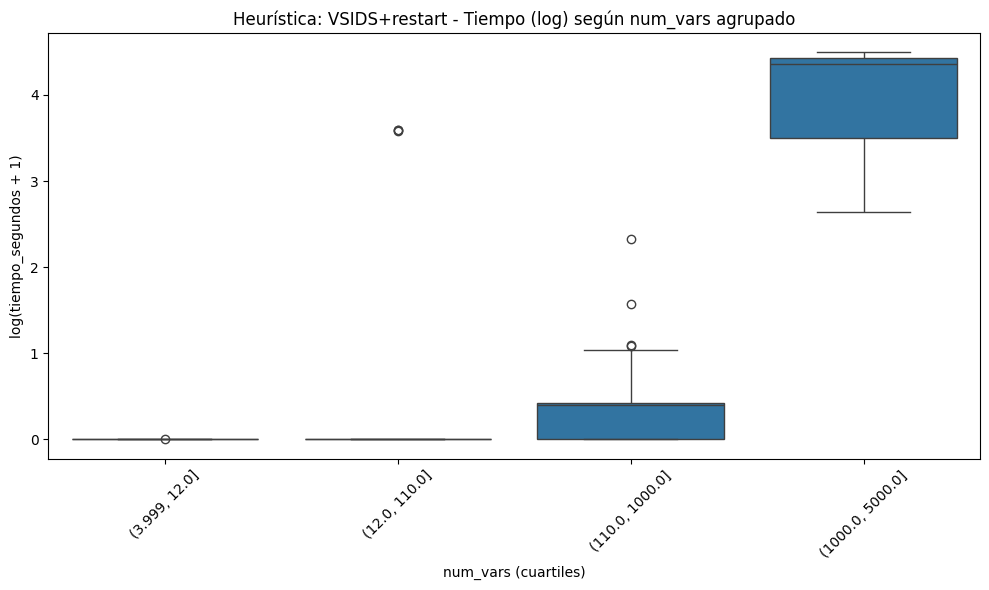

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


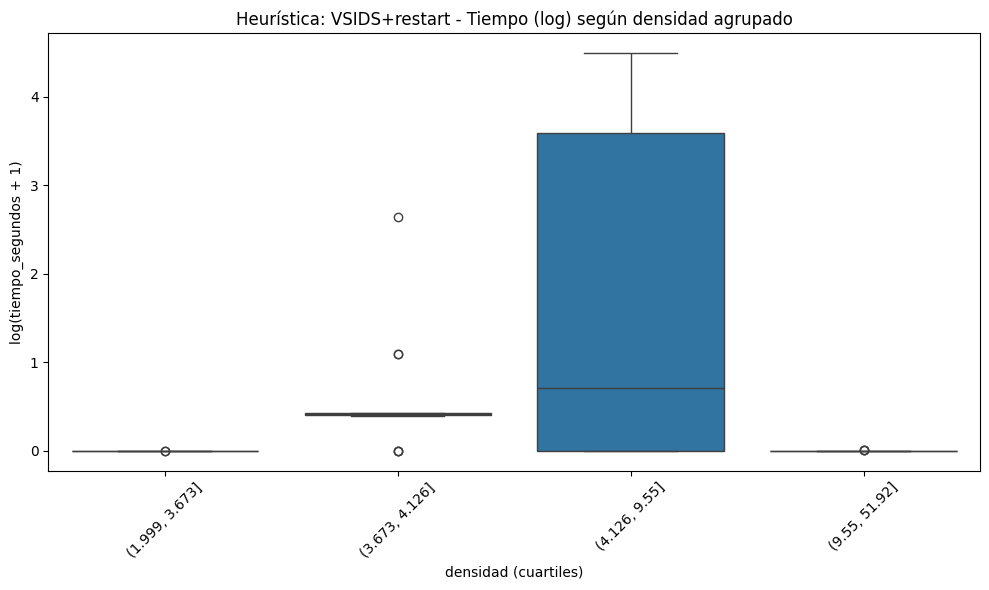

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


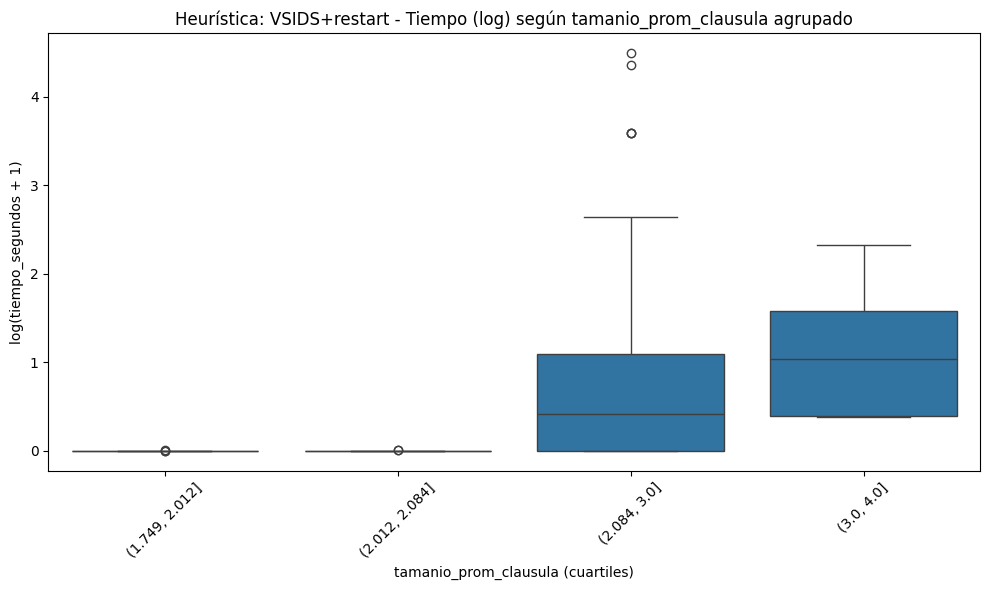

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


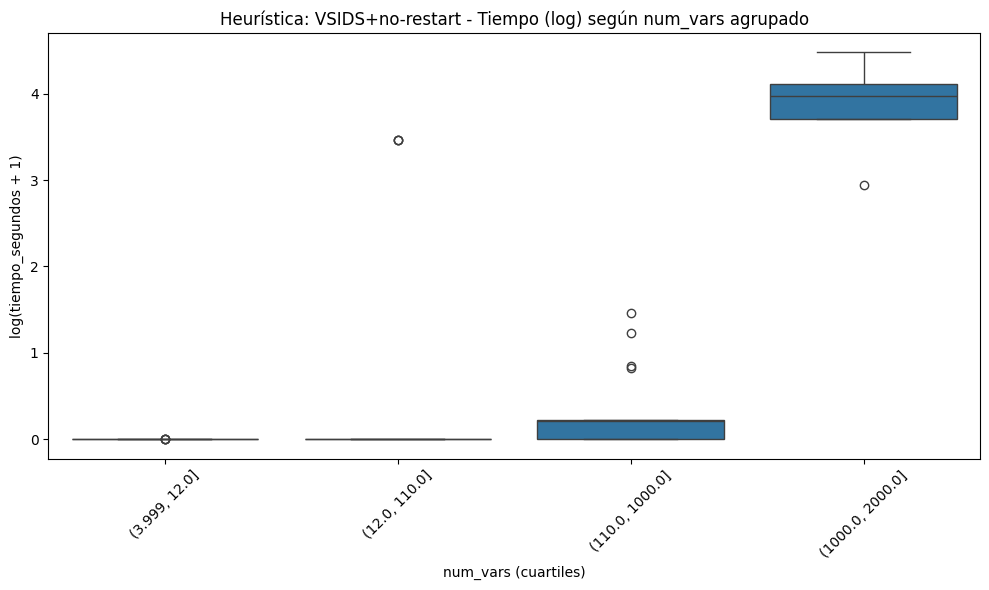

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


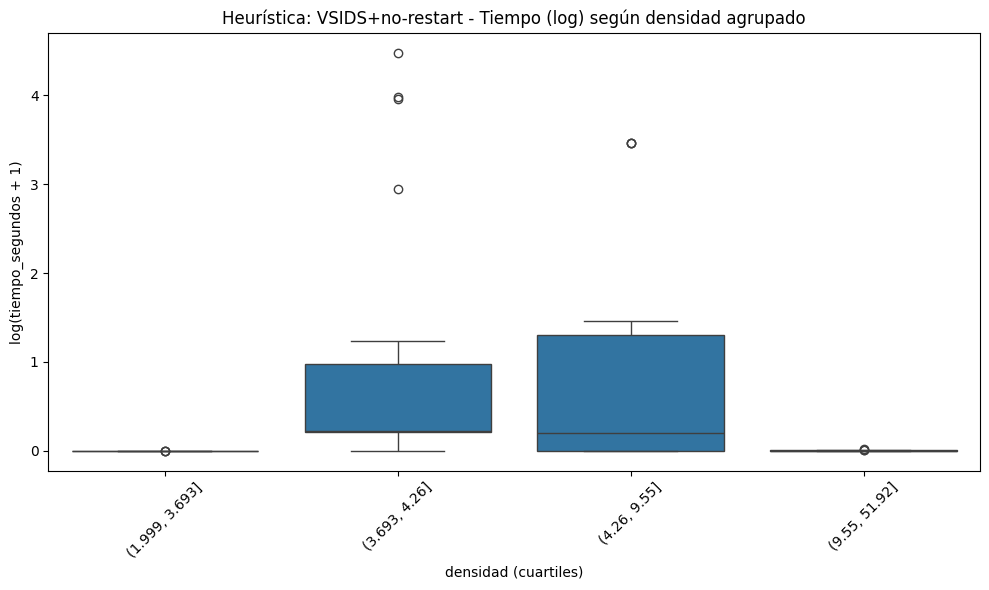

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


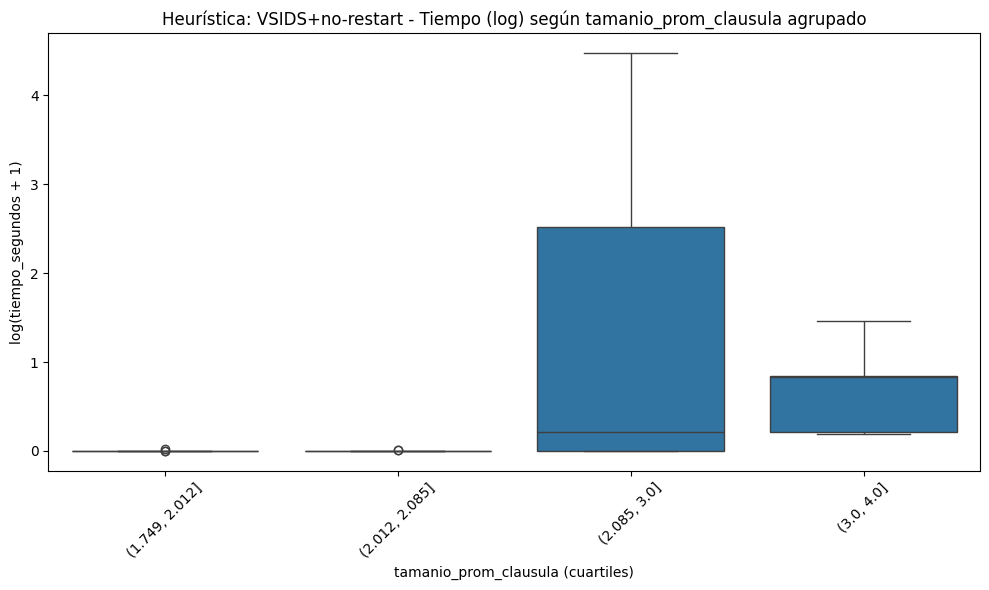

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


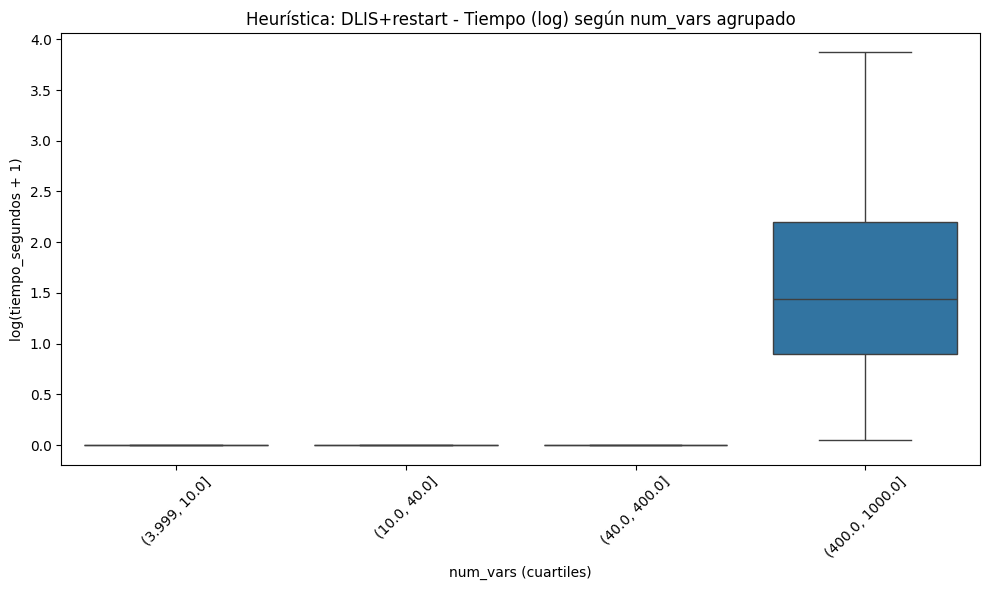

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


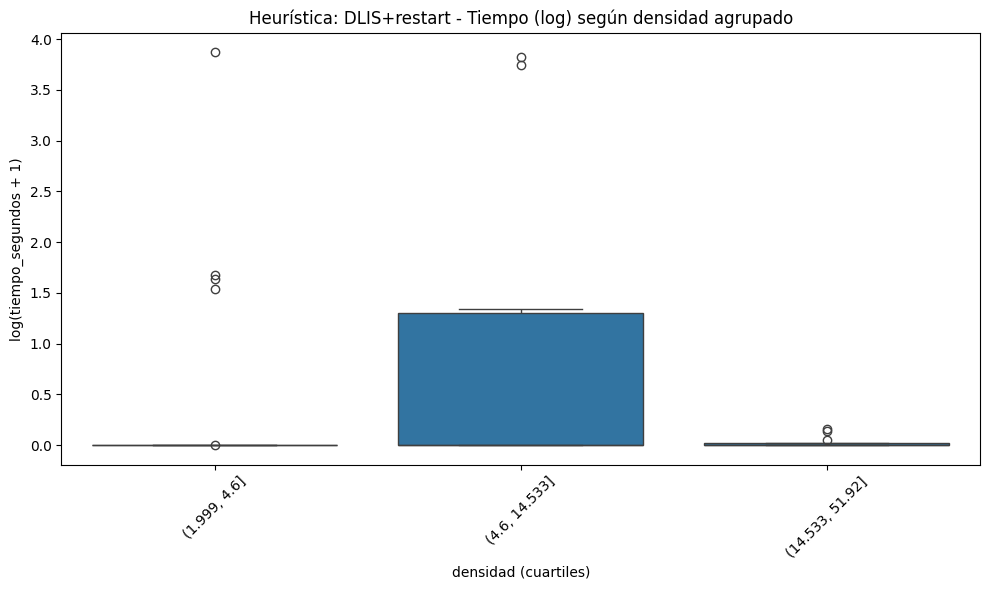

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


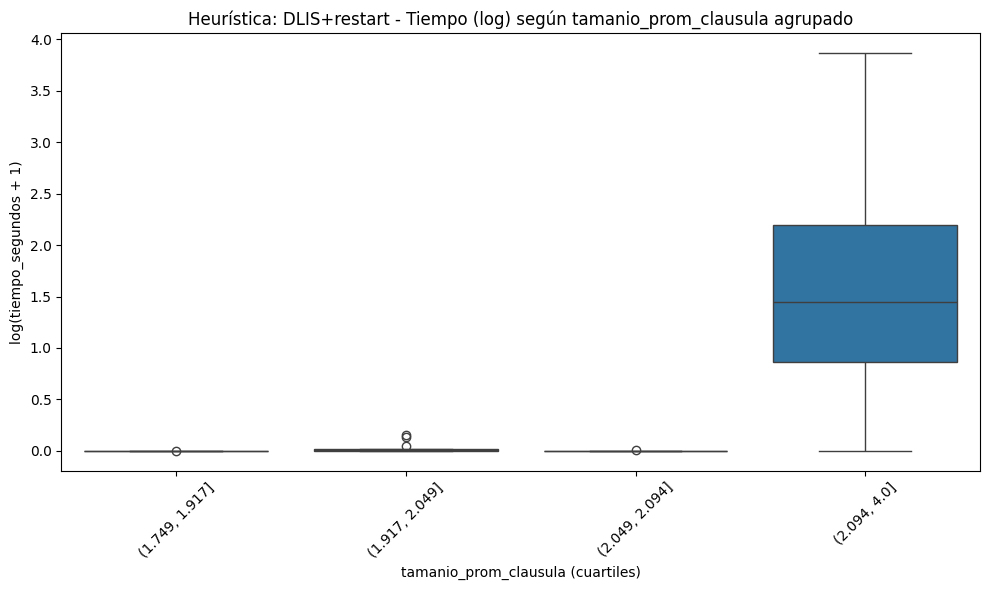

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


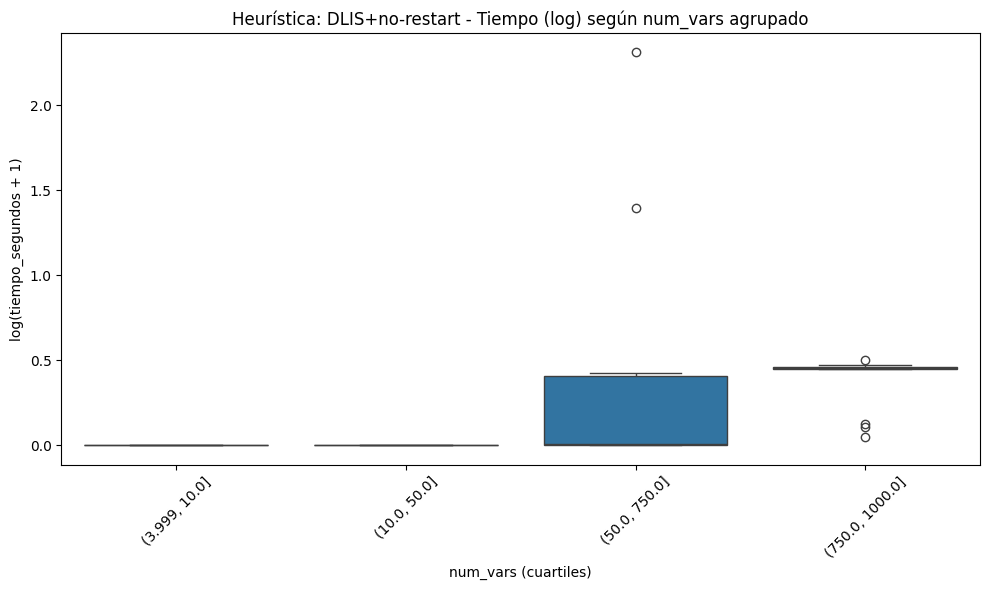

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


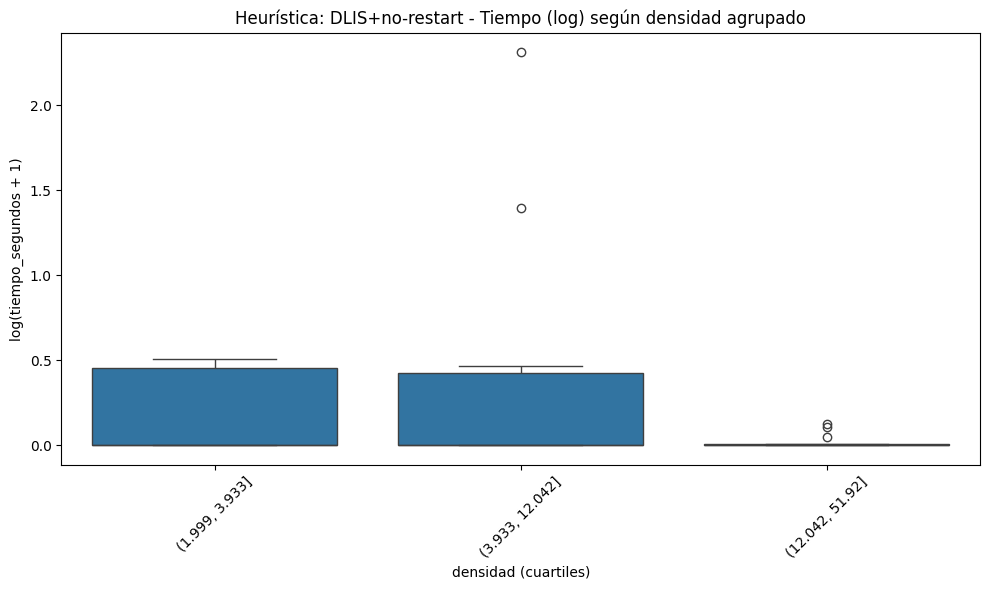

/tmp/ipykernel_4850/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


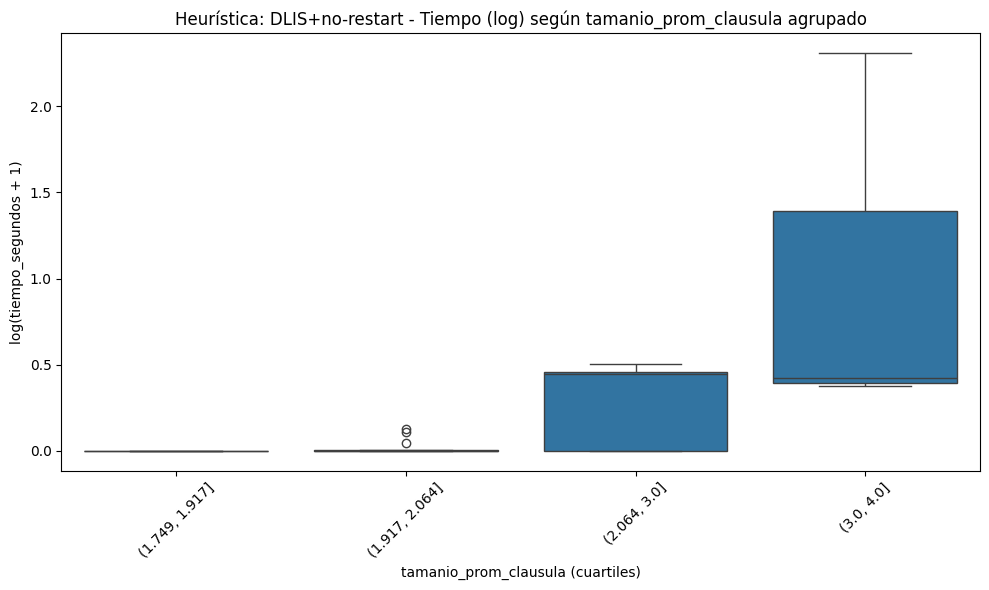

In [20]:

for heuristica in df_solved_reduced['heuristica'].unique():
    df_h = df_solved_reduced[df_solved_reduced['heuristica'] == heuristica]
    
    for var in caracteristicas_reducidas:
        # Discretizar variable en cuartiles para agrupar
        df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')
        
        plt.figure(figsize=(10,6))
        sns.boxplot(x='grupo', y='log_tiempo', data=df_h)
        # Alternativamente, usar sns.violinplot para ver distribución
        # sns.violinplot(x='grupo', y='log_tiempo', data=df_h)
        
        plt.title(f'Heurística: {heuristica} - Tiempo (log) según {var} agrupado')
        plt.xlabel(f'{var} (cuartiles)')
        plt.ylabel('log(tiempo_segundos + 1)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


#### c) Regresión lineal múltiple: ¿Qué características predicen el tiempo de resolución?
Los coeficientes y sus p-valores te indican qué características influyen más en el tiempo de resolución.

In [21]:
X = df_solved_reduced[caracteristicas_reducidas]
X = sm.add_constant(X)
y = df_solved_reduced['tiempo_segundos']

modelo = sm.OLS(y, X).fit()
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:        tiempo_segundos   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     39.21
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           2.01e-20
Time:                        03:47:55   Log-Likelihood:                -860.17
No. Observations:                 229   AIC:                             1728.
Df Residuals:                     225   BIC:                             1742.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.28

Este resultado corresponde a un modelo de regresión lineal múltiple (OLS) que busca explicar la variable dependiente tiempo_segundos a partir de tres variables predictoras: num_vars, densidad y tamanio_prom_clausula.

### Interpretación
El modelo de regresión lineal ordinaria (OLS) ajustado para explicar el tiempo de resolución en función de las variables seleccionadas muestra resultados relevantes y consistentes con análisis previos. El coeficiente positivo y altamente significativo para num_vars (0.0143, p < 0.001) indica que un aumento en el número de variables está asociado con un incremento en el tiempo de resolución, confirmando que el tamaño del problema es un factor determinante en la dificultad computacional. Por otro lado, la densidad presenta un coeficiente negativo significativo (-0.2200, p < 0.001), lo que sugiere que, manteniendo constante el número de variables, problemas con mayor densidad tienden a resolverse más rápido, un hallazgo que puede reflejar características estructurales que facilitan la búsqueda o la poda en el solver. La variable tamaño promedio de cláusula tiene un coeficiente negativo (-2.1268) pero no alcanza significancia estadística al nivel convencional (p = 0.098), indicando un posible efecto en la reducción del tiempo, aunque con menor certeza. El modelo explica aproximadamente el 34.3% de la variabilidad del tiempo (R-squared = 0.343), lo que indica que hay otros factores no incluidos que también influyen en el rendimiento. Se observa además un alto valor en la prueba de Jarque-Bera y una asimetría (skew) considerable, lo que sugiere que los residuos no siguen una distribución normal, y un índice Durbin-Watson de 1.402 que indica cierta autocorrelación residual. La advertencia sobre un número de condición elevado (3.21e+03) señala posibles problemas de multicolinealidad o inestabilidad numérica, aunque las variables seleccionadas fueron previamente reducidas para evitar multicolinealidad severa. 



# Conclusion

**Influencia de las características de los problemas en la eficiencia de las heurísticas**

Los resultados obtenidos a lo largo del análisis evidencian que las características estructurales de los problemas SAT tienen un impacto significativo en la eficiencia de las heurísticas utilizadas en el solver CDCL. En particular, el número de variables se identifica consistentemente como el factor más determinante: problemas con mayor cantidad de variables presentan una mayor probabilidad de terminar en TIMEOUT y requieren tiempos de resolución más largos, independientemente de la heurística aplicada. La densidad (cláusulas por variable) también influye, aunque con un efecto más moderado y en algunos análisis incluso con signo negativo en modelos ajustados, lo que sugiere que problemas más densos pueden ser a veces más fáciles de manejar para ciertas heurísticas. Por último, el tamaño promedio de cláusula tiene un impacto menos claro; aunque correlaciona positivamente con el tiempo en análisis bivariados, en modelos multivariados su efecto es menos significativo y en algunos casos negativo, indicando que su influencia puede depender de interacciones complejas con otras características.
Heurística con mejor rendimiento

**Heurística con mejor rendimiento**

En cuanto al rendimiento comparativo de las heurísticas, los análisis sugieren que no existe una heurística que domine consistentemente en todas las condiciones. Sin embargo, la heurística DLIS+no-restart mostró tiempos medios más bajos en los problemas resueltos y una menor tasa relativa de TIMEOUT en ciertos rangos de tamaño y densidad, lo que puede indicar una mejor eficiencia en problemas medianos a grandes con ciertas estructuras. Por otro lado, las variantes con VSIDS (con y sin reinicio) presentan mayor variabilidad en tiempos y una mayor proporción de TIMEOUT en instancias densas y grandes, aunque también resuelven eficientemente muchos problemas pequeños o medianos. La estrategia de reinicio influye notablemente en el comportamiento, afectando la distribución de tiempos y la tasa de éxito. En resumen, la elección óptima de heurística parece depender fuertemente de las características del problema, y una heurística que adapte su estrategia según el tamaño y la estructura del problema probablemente maximice la eficiencia global.

Estas conclusiones se fundamentan en análisis estadísticos robustos, que incluyen pruebas no paramétricas para diferencias entre grupos, regresiones logísticas para modelar la probabilidad de TIMEOUT, correlaciones de Spearman con el tiempo de resolución, análisis de varianza no paramétricos (Kruskal-Wallis) y pruebas post-hoc (Dunn) para identificar diferencias específicas entre rangos de características, así como modelos lineales para explicar la variabilidad del tiempo. La evidencia empírica sugiere que el rendimiento del solver y la eficacia de las heurísticas dependen de manera crítica de la estructura y tamaño del problema, lo que orienta hacia el desarrollo de estrategias adaptativas y modelos predictivos para mejorar la resolución en la práctica.